### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-29 18:10:56,536 - AInewsbot - INFO - Initializing with before_date=None, do_download=True, thread_id=af62de18016641a49867e07a9e1d9688
2025-04-29 18:10:56,653 - AInewsbot - INFO - thread_id: af62de18016641a49867e07a9e1d9688


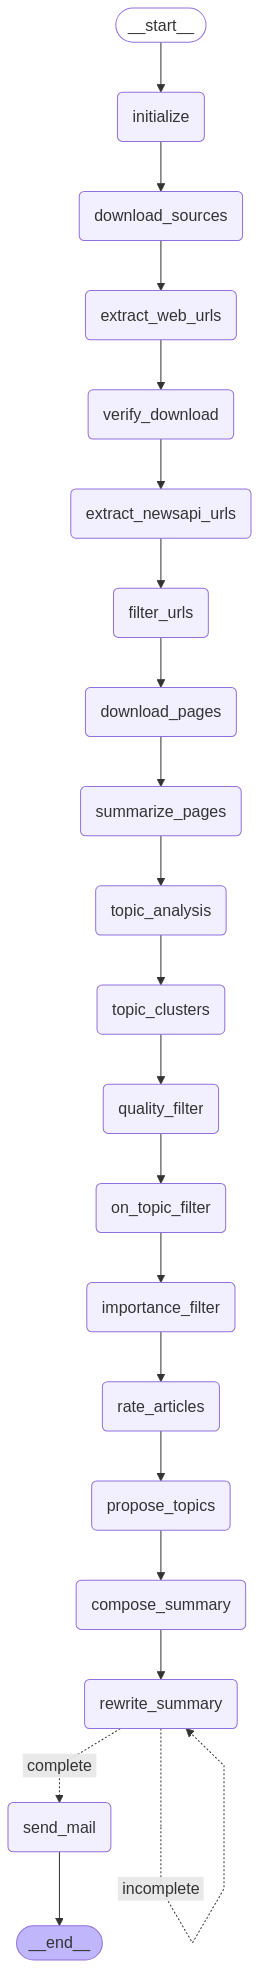

In [4]:
before_date = None
# before_date = '2025-04-26 08:00'
do_download = True

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-04-29 18:14:25,506 - AInewsbot - INFO - Initializing with before_date=2025-04-29 08:00, do_download=False, thread_id=ece912be8c3f4e65b014ade0ccff0e90


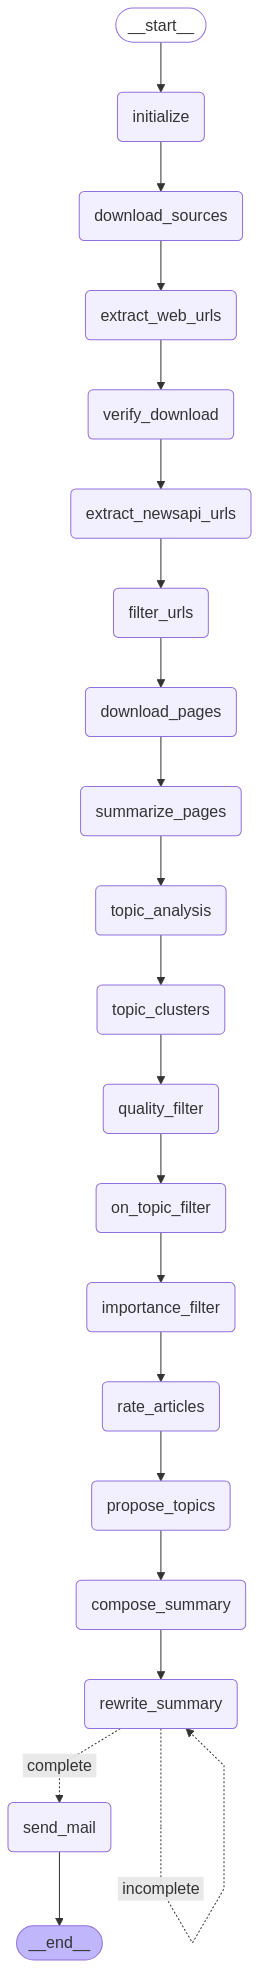

In [10]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-04-29 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [11]:
lg_state = lg_agent.initialize_config(lg_state)


2025-04-29 18:14:26,463 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-29 18:14:26,464 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-04-29 18:14:26,464 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-29 18:14:26,464 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-04-29 18:14:26,465 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-29 18:14:26,465 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-04-29 18:14:26,465 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [12]:
lg_state = lg_agent.download_sources(lg_state)


2025-04-29 18:14:27,203 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-04-29 18:14:27,205 - AInewsbot - INFO - Found 16 previously downloaded files
2025-04-29 18:14:27,206 - AInewsbot - INFO - htmldata/Techmeme.html
2025-04-29 18:14:27,207 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-04-29 18:14:27,207 - AInewsbot - INFO - htmldata/Reddit.html
2025-04-29 18:14:27,207 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-04-29 18:14:27,208 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-04-29 18:14:27,208 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-04-29 18:14:27,209 - AInewsbot - INFO - htmldata/The_Register.html
2025-04-29 18:14:27,209 - AInewsbot - INFO - htmldata/FT.html
2025-04-29 18:14:27,209 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-04-29 18:14:27,210 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-04-29 18:14:27,210 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-04-29 18:14:27,211 - AInewsbot - INFO -

In [13]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-04-29 18:14:29,635 - AInewsbot - INFO - Parsing html files
2025-04-29 18:14:29,636 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-04-29 18:14:29,697 - AInewsbot - INFO - parse_file - found 174 raw links
2025-04-29 18:14:29,701 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-04-29 18:14:29,702 - AInewsbot - INFO - 36 links found
2025-04-29 18:14:29,702 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-04-29 18:14:29,732 - AInewsbot - INFO - parse_file - found 250 raw links
2025-04-29 18:14:29,734 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-04-29 18:14:29,734 - AInewsbot - INFO - 37 links found
2025-04-29 18:14:29,735 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-04-29 18:14:29,756 - AInewsbot - INFO - parse_file - found 211 raw links
2025-04-29 18:14:29,759 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-04-29 18:14:29,759 - AInewsbot - INFO - 21 links found
2025-04-29

In [14]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,36
Bloomberg,30
Business Insider,21
FT,67
Feedly AI,32
Hacker News 1,28
Hacker News 2,24
HackerNoon,28
New York Times,18


number of missing sources 0


set()

In [15]:
lg_state = lg_agent.verify_download(lg_state)


2025-04-29 18:14:38,671 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [16]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-04-29 18:14:39,720 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-28T18:14:39 from NewsAPI


In [17]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-04-29 18:14:40,645 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-29 08:00'
2025-04-29 18:14:41,219 - AInewsbot - INFO - URLs in orig_df: 843
2025-04-29 18:14:41,223 - AInewsbot - INFO - Existing URLs in DB: 251818
2025-04-29 18:14:41,292 - AInewsbot - INFO - New URLs in df filtered by URL: 331
2025-04-29 18:14:41,435 - AInewsbot - INFO - Existing src+title: 28
2025-04-29 18:14:41,436 - AInewsbot - INFO - New URLs in df filtered by src+title: 303
2025-04-29 18:14:41,450 - AInewsbot - INFO - Found 303 unique new headlines
2025-04-29 18:14:41,452 - AInewsbot - INFO - Found 298 unique cleaned new headlines
2025-04-29 18:14:50,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:14:50,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:14:50,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,4
Bloomberg,6
Business Insider,2
FT,1
Feedly AI,27
Hacker News 1,5
Hacker News 2,4
HackerNoon,1
NewsAPI,36


In [18]:
lg_state = lg_agent.download_pages(lg_state)


2025-04-29 18:14:55,689 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-29 18:14:55,697 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-04-29 18:14:55,894 - AInewsbot - INFO - Launching browser
2025-04-29 18:14:56,880 - AInewsbot - INFO - Launching workers
2025-04-29 18:14:56,880 - AInewsbot - INFO - Finishing and closing browser
2025-04-29 18:14:56,881 - AInewsbot - INFO - Launching worker
2025-04-29 18:14:56,881 - AInewsbot - INFO - from queue: 0, https://www.pcgamer.com/games/battle-royale/ai-is-going-to-become-more-and-more-difficult-to-detect-fortnite-has-no-plans-to-clean-up-increasing-number-of-ai-thumbnails-cluttering-up-user-generated-experiences/, 'AI is going to become more and more difficult to detect': Fortnite has no plans to clean up increasing number of AI thumbnails cluttering up user-generated experiences
2025-04-29 18:14:56,881 - AInewsbot - INFO - fetch_url(https://www.pcgamer.com/games/battle-royale/ai-is-going-to-become-more-and-more-

2025-04-29 18:15:57,200 - AInewsbot - INFO - from queue: 14, https://github.com/PhialsBasement/Chain-of-Recursive-Thoughts, Chain of Recursive Thoughts: Make AI think harder by making it argue with itself
2025-04-29 18:15:57,200 - AInewsbot - INFO - fetch_url(https://github.com/PhialsBasement/Chain-of-Recursive-Thoughts)
2025-04-29 18:15:57,707 - AInewsbot - INFO - Error fetching https://arstechnica.com/security/2025/04/ai-generated-code-could-be-a-disaster-for-the-software-supply-chain-heres-why/: Page.goto: Timeout 60000ms exceeded.
Call log:
  - navigating to "https://arstechnica.com/security/2025/04/ai-generated-code-could-be-a-disaster-for-the-software-supply-chain-heres-why/", waiting until "load"

2025-04-29 18:15:57,707 - AInewsbot - INFO - from queue: 15, https://biztoc.com/x/05c42b0f95415f82, ChatGPT AI bot adds shopping to its powers
2025-04-29 18:15:57,708 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/05c42b0f95415f82)
2025-04-29 18:16:11,509 - AInewsbot - INFO - Savi

2025-04-29 18:17:18,441 - AInewsbot - INFO - fetch_url(https://www.techtarget.com/searchenterpriseai/news/366623313/Deriving-ROI-from-AI-is-more-than-just-monetary-value)
2025-04-29 18:17:20,162 - AInewsbot - INFO - Saving HTML to htmlpages/Colorado_AI_bill_set_for_overhaul_as_the_clock_ticks.html
2025-04-29 18:17:20,506 - AInewsbot - INFO - from queue: 29, https://publishingperspectives.com/2025/04/abu-dhabi-international-book-fair/, Digitizing Creativity: Potential and Promise at Abu Dhabi
2025-04-29 18:17:20,507 - AInewsbot - INFO - fetch_url(https://publishingperspectives.com/2025/04/abu-dhabi-international-book-fair/)
2025-04-29 18:17:32,294 - AInewsbot - INFO - Saving HTML to htmlpages/ChatGPT_AI_bot_adds_shopping_to_its_powers.html
2025-04-29 18:17:32,424 - AInewsbot - INFO - from queue: 30, https://www.pcmag.com/news/duolingo-adopts-ai-first-strategy-will-eliminate-all-contract-workers, Duolingo Adopts AI-First Strategy, Will Eliminate All Contract Workers
2025-04-29 18:17:32,4

2025-04-29 18:18:56,708 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/04/29/google-launches-ai-tools-for-practicing-languages-through-personalized-lessons/)
2025-04-29 18:18:56,710 - AInewsbot - INFO - Waiting 9.764035439459832 seconds to rate limit techcrunch.com 22.5068898749887
2025-04-29 18:19:00,626 - AInewsbot - INFO - Saving HTML to htmlpages/Ferrari_reveal_one-off_team_kit_and_AI-defined_HP_livery_for_this_weekend_s_Miami_Grand_Prix.html
2025-04-29 18:19:00,918 - AInewsbot - INFO - from queue: 45, https://arstechnica.com/ai/2025/04/google-searchs-made-up-ai-explanations-for-sayings-no-one-ever-said-explained/, Google searchs made-up AI explanations for sayings no one ever said, explained
2025-04-29 18:19:00,919 - AInewsbot - INFO - fetch_url(https://arstechnica.com/ai/2025/04/google-searchs-made-up-ai-explanations-for-sayings-no-one-ever-said-explained/)
2025-04-29 18:19:27,139 - AInewsbot - INFO - Saving HTML to htmlpages/Generative_AI_is_not_replacing_jobs_or_hur

2025-04-29 18:21:33,962 - AInewsbot - INFO - from queue: 59, https://www.theregister.com/2025/04/29/metas_standalone_ai_app/, Meta bets you want a sprinkle of social in your chatbotSharing is caring when your entire business is built on itAI + ML35 mins|
2025-04-29 18:21:33,963 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/04/29/metas_standalone_ai_app/)
2025-04-29 18:21:37,943 - AInewsbot - INFO - Saving HTML to htmlpages/Mastercard_Gives_AI_Agents_Ability_To_Shop_Online_for_You.html
2025-04-29 18:21:38,241 - AInewsbot - INFO - from queue: 60, https://techcrunch.com/2025/04/29/meta-previews-an-api-for-its-llama-ai-models/, Meta debuts an API for its Llama AI models, in limited preview with pricing yet to be publicly announced
2025-04-29 18:21:38,243 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/04/29/meta-previews-an-api-for-its-llama-ai-models/)
2025-04-29 18:21:38,602 - AInewsbot - INFO - Saving HTML to htmlpages/Intel_s_next_chip_node__14A__is_slated_

2025-04-29 18:23:52,008 - AInewsbot - INFO - Saving HTML to htmlpages/Microsoft_and_Amazon_Capex_in_Focus_Amid_Potential_AI_Pullback.html
2025-04-29 18:23:52,891 - AInewsbot - INFO - from queue: 73, https://www.commondreams.org/news/killer-robots-hrw-inernational-treaty, Not Just for the Battlefield: Rights Group Warns of Dystopian World Where Killer Robots Reign
2025-04-29 18:23:52,892 - AInewsbot - INFO - fetch_url(https://www.commondreams.org/news/killer-robots-hrw-inernational-treaty)
2025-04-29 18:23:55,469 - AInewsbot - INFO - Saving HTML to htmlpages/Meta_unleashes_Llama_API_running_18x_faster_than_OpenAI__Cerebras_partnership_delivers_2_600_tokens_per_second.html
2025-04-29 18:23:56,115 - AInewsbot - INFO - Saving HTML to htmlpages/Meta_s_first_dedicated_AI_app_is_here_with_Llama_4__but_it_s_more_consumer_than_productivity_or_business_oriented.html
2025-04-29 18:23:56,326 - AInewsbot - INFO - from queue: 74, https://biztoc.com/x/6d3c06e8cf798839, Nvidia Stock Drops on Report Hu

2025-04-29 18:26:07,406 - AInewsbot - INFO - from queue: 89, https://www.reuters.com/world/china/trump-officials-eye-changes-bidens-ai-chip-export-rule-sources-say-2025-04-29/, Sources: Trump officials are considering removing a Biden-era rule that divides the world into tiers that help determine how many AI chips a country can obtain (Karen Freifeld/Reuters)
2025-04-29 18:26:07,407 - AInewsbot - INFO - fetch_url(https://www.reuters.com/world/china/trump-officials-eye-changes-bidens-ai-chip-export-rule-sources-say-2025-04-29/)
2025-04-29 18:26:08,276 - AInewsbot - INFO - Saving HTML to htmlpages/Reddit_Issuing__Formal_Legal_Demands__Against_Researchers_Who_Conducted_Secret_AI_Experiment_on_Users.html
2025-04-29 18:26:08,862 - AInewsbot - INFO - from queue: 90, https://techcrunch.com/2025/04/29/startups-launch-products-to-catch-people-using-ai-cheating-app-cluely/, Startups launch products to catch people using AI cheating app Cluely
2025-04-29 18:26:08,872 - AInewsbot - INFO - fetch_ur

2025-04-29 18:29:41,504 - AInewsbot - INFO - from queue: 103, https://petapixel.com/2025/04/28/uk-childrens-commissioner-calls-for-ban-on-ai-nudification-apps/, UK Childrens Commissioner Calls for Ban on AI Nudification Apps
2025-04-29 18:29:41,505 - AInewsbot - INFO - fetch_url(https://petapixel.com/2025/04/28/uk-childrens-commissioner-calls-for-ban-on-ai-nudification-apps/)
2025-04-29 18:29:47,266 - AInewsbot - INFO - Saving HTML to htmlpages/Tesla_wont_have_to_report_as_many_Level_2_crashes_after_Trumps_rule_change___Tesla_represents_the_bulk_of_the_Level_2_automated_crashes_to_the_federal_government..html
2025-04-29 18:29:48,242 - AInewsbot - INFO - from queue: 104, https://financialpost.com/technology/ups-figure-ai-deploy-humanoid-robots, UPS in talks with startup Figure AI to deploy humanoid robots
2025-04-29 18:29:48,245 - AInewsbot - INFO - fetch_url(https://financialpost.com/technology/ups-figure-ai-deploy-humanoid-robots)
2025-04-29 18:30:26,036 - AInewsbot - INFO - Saving HT

In [19]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-04-29 18:34:09,141 - AInewsbot - INFO - Starting summarize
2025-04-29 18:34:09,146 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-29 18:34:09,151 - AInewsbot - INFO - No path for 0
2025-04-29 18:34:09,160 - AInewsbot - INFO - No article_str for 0
2025-04-29 18:34:09,234 - AInewsbot - INFO - clean_html - Page title: AI Godfather Geoffrey Hinton Warns: 1-in-5 Chance of Machines Taking Over - Slashdot
Social card title: AI Godfather Geoffrey Hinton Warns: 1-in-5 Chance of Machines Taking Over - Slashdot
Social card description: Geoffrey Hinton, one of the renowned pioneers often referred to as the "Godfathers of AI," is raising fresh alarms about the dangers posed by the fast-moving and loosely regulated AI industry. Hinton cautions that most people remain unaware of the risks ahead, warning there is a 10 to 20 percent cha...



None
htmlpages/AI_Godfather_Geoffrey_Hinton_Warns__1-in-5_Chance_of_Machines_Taking_Over.html


2025-04-29 18:34:09,621 - AInewsbot - INFO - Queuing 1: Page title: AI Godfather Geoffrey Hinton Warns: 1-...
2025-04-29 18:34:09,634 - AInewsbot - INFO - clean_html - Page title: AI and Democracy: Scholars Unpack the Intersection of Technology and Governance
 | Institution for Social and Policy Studies

2025-04-29 18:34:09,665 - AInewsbot - INFO - Queuing 2: Page title: AI and Democracy: Scholars Unpack the ...
2025-04-29 18:34:09,771 - AInewsbot - INFO - clean_html - Page title: AI exposure for TN young minds | India News - The Times of India
Social card title: AI exposure for TN young minds | India News - The Times of India
Social card description: India News: Tamil Nadu government schools will introduce artificial intelligence and emerging technologies to students in classes VI to IX starting this academic 



htmlpages/AI_and_democracy__Scholars_unpack_the_intersection_of_technology_and_governance.html
htmlpages/AI_exposure_for_TN_young_minds.html


2025-04-29 18:34:09,955 - AInewsbot - INFO - Queuing 3: Page title: AI exposure for TN young minds | India...
2025-04-29 18:34:09,988 - AInewsbot - INFO - clean_html - Page title: AI was used to write the California bar exam. The law community is outraged. | Mashable
Social card title: AI was used to write the California bar exam. The law community is outraged.
Social card description: An outsourced contractor relied on AI to help write some of the exam questions.

2025-04-29 18:34:10,033 - AInewsbot - INFO - Queuing 4: Page title: AI was used to write the California ba...
2025-04-29 18:34:10,034 - AInewsbot - INFO - No path for 5
2025-04-29 18:34:10,034 - AInewsbot - INFO - No article_str for 5
2025-04-29 18:34:10,048 - AInewsbot - INFO - clean_html - Page title: Alibaba launches open source Qwen3 besting OpenAI o1 | VentureBeat
Social card title: Alibaba launches open source Qwen3 model that surpasses OpenAI o1 and DeepSeek R1
Social card description: Qwen3’s open-weight release unde

htmlpages/AI_was_used_to_write_the_California_bar_exam._The_law_community_is_outraged..html
None
htmlpages/Alibaba_launches_open_source_Qwen3_model_that_surpasses_OpenAI_o1_and_DeepSeek_R1.html
htmlpages/Amazon_CEO_Andy_Jassy_has_a_warning_about_how_fast_people_are_embracing_AI.html
htmlpages/Amazon-Backed_Glacier_Raises__16_Million_for_AI-Powered_Recycling_Robots.html
htmlpages/Anthropic_Forms_Council_to_Explore_AIs_Economic_Implications.html
htmlpages/Anthropic-Backed_Goodfire_Raises__50_Million_to_Access_AIs_Internal_Thoughts.html
htmlpages/Around_50__of_US_adults_say_AI_will_have_a_negative_impact_on_news_over_the_next_20_years__10__say_a_positive_effect__59__say_AI_will_lead_to_fewer_journalists__Michael_Lipka_Pew_Research_Center.html


2025-04-29 18:34:10,712 - AInewsbot - INFO - clean_html - Page title: Mediagazer: Survey: 50% of US adults say AI will have a negative impact on news over the next 20 years while 10% say positive; 59% say AI will lead to fewer journalist jobs (Michael Lipka/Pew Research Center)
Social card title: Survey: 50% of US adults say AI will have a negative impact on news over the next 20 years while 10% say positive; 59% say AI will lead to fewer journalist jobs
Social card description: By Michael Lipka / Pew Research Center. View the full context on Mediagazer.

2025-04-29 18:34:10,800 - AInewsbot - INFO - Queuing 11: Page title: Mediagazer: Survey: 50% of US adults s...
2025-04-29 18:34:10,813 - AInewsbot - INFO - clean_html - Page title: Meet Bamba, IBM’s new attention-state space model - IBM Research
Social card title: Meet Bamba, IBM’s new attention-state space model
Social card description: The open-source LLM combines the sequence-modeling skill of a transformer with the inferencing spe

htmlpages/Bamba__An_open-source_LLM_that_crosses_a_transformer_with_an_SSM.html
htmlpages/Build_AI_Agents_Course_For_Software_Engineers__Technical_Product_Managers_and_Engineering_Managers_Launch_-_Interview_Kickstarts_Agentic_AI_Masterclass_2025.html
htmlpages/Chain_of_Recursive_Thoughts__Make_AI_think_harder_by_making_it_argue_with_itself.html
htmlpages/ChatGPT_AI_bot_adds_shopping_to_its_powers.html
htmlpages/ChatGPT_goes_shopping_with_new_product-browsing_feature.html
htmlpages/ChatGPT_is_your_personal_shopper_now.html


2025-04-29 18:34:11,044 - AInewsbot - INFO - Queuing 17: Page title: ChatGPT is your personal shopper now -...
2025-04-29 18:34:11,123 - AInewsbot - INFO - clean_html - Page title: Chatgpt induced psychosis : r/ChatGPT

2025-04-29 18:34:11,181 - AInewsbot - INFO - Queuing 18: Page title: Chatgpt induced psychosis : r/ChatGPT
...
2025-04-29 18:34:11,183 - AInewsbot - INFO - clean_html - Page title: wsj.com



htmlpages/Chatgpt_induced_psychosis.html
htmlpages/China_s_Pony.ai_says_it_can_now_build_its_most_advanced_autonomous_driving_system_for_70__less_and_plans_to_start_mass_production_of_its_robotaxis_in_mid-2025.html


2025-04-29 18:34:11,283 - trafilatura.core - WARNING - discarding data: None
2025-04-29 18:34:11,284 - AInewsbot - INFO - Queuing 19: Page title: wsj.com
...
2025-04-29 18:34:11,372 - AInewsbot - INFO - clean_html - Page title: Teradyne (TER) Beats Q1 Earnings and Revenue Estimates
Social card title: Teradyne (TER) Beats Q1 Earnings and Revenue Estimates
Social card description: Teradyne (TER) delivered earnings and revenue surprises of 22.95% and 0.26%, respectively, for the quarter ended March 2025. Do the numbers hold clues to what lies ahead for the stock?



htmlpages/Chip_design_software_maker_Cadence_raises_annual_forecasts_on_steady_AI_demand.html


2025-04-29 18:34:11,485 - AInewsbot - INFO - Queuing 20: Page title: Teradyne (TER) Beats Q1 Earnings and R...
2025-04-29 18:34:11,488 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-29 18:34:11,490 - AInewsbot - INFO - Queuing 21: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-29 18:34:11,500 - AInewsbot - INFO - clean_html - Page title: Colorado AI bill set for overhaul as the session clock ticks - Axios Denver
Social card title: Colorado's AI rules are set for overhaul after tech industry blowback
Social card description: Other states are closely watching the lawmaking as a model for regulating AI and ensuring privacy in the bot era.

2025-04-29 18:34:11,533 - AInewsbot - INFO - Queuing 22: Page title: Colorado AI bill set for overhaul as t...
2025-04-29 18:34:11,577 - AInewsbot - INFO - clean_html - Page title: Conservative activist Robby Starbuck sues Meta for defamation over AI chatbot answers
Social card title: Conservative acti

htmlpages/Chipmaking_equipment_manufacturer_ASM_says_orders_in_Q1_rose_14__YoY_to_834M__vs._808M_est.__but_notes_demand_in_non-AI-related_segments_was_sluggish.html
htmlpages/Colorado_AI_bill_set_for_overhaul_as_the_clock_ticks.html
htmlpages/Conservative_activist_Robby_Starbuck_sues_Meta_over_AI_chatbot_claim_he_participated_in_Jan._6_riot.html
htmlpages/CrowdStrike_introduces_new_tools_for_blocking_malicious_AI_models__data_exfiltration.html
htmlpages/DOJ_Google_Antitrust_Case_Wraps_With_Generative_AI_in_Spotlight.html
htmlpages/Dan_Niles_Says_NVIDIA__NVDA___5.5_Billion_Charge_Shows_Demand_Issues__They_Cant_Resell_Chips_Anywhere_Else.html


2025-04-29 18:34:11,759 - AInewsbot - INFO - clean_html - Page title: Best long-term ETFs to buy and hold
Social card title: Best long-term ETFs to buy and hold
Social card description: Here are some top long-term ETFs to add to your investment portfolio.

2025-04-29 18:34:11,878 - AInewsbot - INFO - Queuing 26: Page title: Best long-term ETFs to buy and hold
So...
2025-04-29 18:34:11,880 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-29 18:34:11,883 - AInewsbot - INFO - Queuing 27: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-29 18:34:11,895 - AInewsbot - INFO - clean_html - Page title: Deriving ROI from AI is more than just monetary value | TechTarget
Social card title: Deriving ROI from AI is more than just monetary value | TechTarget
Social card description: While enterprises would like to see monetary ROI from using AI tools, they can realize other forms of value.

2025-04-29 18:34:11,910 - AInewsbot - INFO - Queuing 28: Page t

htmlpages/Deepfake_Revenge_Porn_Bill_Heads_to_Trump_for_His_Signature.html
htmlpages/Deriving_ROI_from_AI_is_more_than_just_monetary_value.html
htmlpages/Digitizing_Creativity__Potential_and_Promise_at_Abu_Dhabi.html
htmlpages/Duolingo_Adopts_AI-First_Strategy__Will_Eliminate_All_Contract_Workers.html


2025-04-29 18:34:12,127 - AInewsbot - INFO - clean_html - Page title: Duolingo Adopts ‘AI-First’ Strategy, Will Eliminate All Contract Workers | PCMag
Social card title: Duolingo Adopts ‘AI-First’ Strategy, Will Eliminate All Contract Workers
Social card description: AI will help 'teach well' and generate content at scale, says Duolingo CEO Luis von Ahn. The company will also be using AI for hiring and performance reviews.

2025-04-29 18:34:12,196 - AInewsbot - INFO - Queuing 30: Page title: Duolingo Adopts ‘AI-First’ Strategy, W...
2025-04-29 18:34:12,213 - AInewsbot - INFO - clean_html - Page title: Duolingo ditches more contractors in 'AI-first' refocus • The Register
Social card title: Duolingo ditches more contractors in 'AI-first' refocus
Social card description: : Luis von Ahn says small quality hits are a price worth paying to ride the wave

2025-04-29 18:34:12,239 - AInewsbot - INFO - Queuing 31: Page title: Duolingo ditches more contractors in '...
2025-04-29 18:34:12,264 - A

htmlpages/Duolingo_jumps_aboard_the__AI-first__train__will_phase_out_contractorsLuis_von_Ahn_says_small_quality_hits_are_a_price_worth_paying_to_ride_the_waveAI___ML5_hrs_18.html
htmlpages/Duolingo_will_replace_contract_workers_with_AI.html
htmlpages/Escape_the_AIpocalypse__Essential_Strategies_for_Developers.html
htmlpages/Everything_we_announced_at_our_first_LlamaCon.html


2025-04-29 18:34:12,423 - AInewsbot - INFO - Queuing 34: Page title: Everything we announced at our first-e...
2025-04-29 18:34:12,434 - AInewsbot - INFO - clean_html - Page title: Ex-School Athletic Director Gets 4 Months in Jail for Racist Deepfake Recording - The New York Times
Social card title: Ex-School Athletic Director Gets 4 Months in Jail for Racist Deepfake Recording
Social card description: Dazhon Darien, 32, who worked at Pikesville High School in Baltimore County, pleaded guilty to disturbing school operations.

2025-04-29 18:34:12,451 - AInewsbot - INFO - Queuing 35: Page title: Ex-School Athletic Director Gets 4 Mon...
2025-04-29 18:34:12,462 - AInewsbot - INFO - clean_html - Page title: Ferrari reveal one-off team kit and AI-defined HP livery for this weekend's Miami Grand Prix - F1technical.net

2025-04-29 18:34:12,472 - AInewsbot - INFO - Queuing 36: Page title: Ferrari reveal one-off team kit and AI...
2025-04-29 18:34:12,480 - AInewsbot - INFO - clean_html - Page t

htmlpages/Ex-School_Athletic_Director_Gets_4_Months_in_Jail_for_Racist_Deepfake_Recording.html
htmlpages/Ferrari_reveal_one-off_team_kit_and_AI-defined_HP_livery_for_this_weekend_s_Miami_Grand_Prix.html
htmlpages/Flashpoint_Unveils_New_AI-Powered_Risk_Discovery__Curated_Threat_Feeds__and_On-Demand_Data_Source_Expansion_at_RSA_Conference_2025.html
htmlpages/For_professional_service_firms__AI_is_a_big_helpbut_also_a_potential_existential_threat.html


2025-04-29 18:34:12,877 - AInewsbot - INFO - clean_html - Page title: NTT Data's head of generative AI says the technology is a boon to consultants—but also a potential threat | Fortune
Social card title: In the AI era, will anyone still need consultants?
Social card description: AI is automating key business tasks. But does that mean business consultants will be replaced too?

2025-04-29 18:34:12,922 - AInewsbot - INFO - Queuing 38: Page title: NTT Data's head of generative AI says ...
2025-04-29 18:34:12,953 - AInewsbot - INFO - clean_html - Page title: Freepik releases an 'open' AI image generator trained on licensed data | TechCrunch
Social card title: Freepik releases an 'open' AI image generator trained on licensed data | TechCrunch
Social card description: Freepik has released an 'open' AI image generator, F Lite, trained on licensed data. It requires beefy hardware to run, however.

2025-04-29 18:34:13,001 - AInewsbot - INFO - Queuing 39: Page title: Freepik releases an 'open' 

htmlpages/Freepik_releases_an_open_AI_image_generator_trained_on_licensed_data.html
htmlpages/Future_weapons__Battlefield_AI.html
htmlpages/Gaussian_Splatting_Meets_ROS2.html
htmlpages/Generative_AI_is_not_replacing_jobs_or_hurting_wages_at_all__say_economists.html


2025-04-29 18:34:13,152 - AInewsbot - INFO - Queuing 42: Page title: Generative AI is not replacing jobs or...
2025-04-29 18:34:13,177 - AInewsbot - INFO - clean_html - Page title: Google is turning your favorite AI podcast hosts into polyglots | TechRadar
Social card title: Google is turning your favorite AI podcast hosts into polyglots
Social card description: NotebookLM Audio Overviews will chat in dozens of languages

2025-04-29 18:34:13,211 - AInewsbot - INFO - Queuing 43: Page title: Google is turning your favorite AI pod...
2025-04-29 18:34:13,251 - AInewsbot - INFO - clean_html - Page title: Google launches AI tools for practicing languages through personalized lessons | TechCrunch
Social card title: Google launches AI tools for practicing languages through personalized lessons | TechCrunch
Social card description: Google on Tuesday is releasing three new AI experiments aimed at helping people learn to speak a new language in a more personalized way. While the

2025-04-29 18:34

htmlpages/Google_is_turning_your_favorite_AI_podcast_hosts_into_polyglots.html
htmlpages/Google_launches_AI_tools_for_practicing_languages_through_personalized_lessons.html
htmlpages/Google_searchs_made-up_AI_explanations_for_sayings_no_one_ever_said__explained.html


2025-04-29 18:34:13,357 - AInewsbot - INFO - Queuing 45: Page title: Google search’s made-up AI explanation...
2025-04-29 18:34:13,358 - AInewsbot - INFO - No path for 46
2025-04-29 18:34:13,358 - AInewsbot - INFO - No article_str for 46
2025-04-29 18:34:13,397 - AInewsbot - INFO - clean_html - Page title: How AI Image Upscaling Enhances Visual Content For Marketing And Sales | Martech Zone
Social card title: How AI Image Upscaling Enhances Visual Content For Marketing And Sales | Martech Zone
Social card description: Learn how AI image upscaling enhances visual content for marketing and sales purposes.

2025-04-29 18:34:13,432 - AInewsbot - INFO - Queuing 47: Page title: How AI Image Upscaling Enhances Visual...
2025-04-29 18:34:13,458 - AInewsbot - INFO - clean_html - Page title: How AI can help utilities detect wildfire threats
Social card title: How AI can help utilities detect wildfire threats
Social card description: Pano AI co-founder Arvind Satyam explains how his company's tec

None
htmlpages/How_AI_Image_Upscaling_Enhances_Visual_Content_for_Marketing_and_Sales.html
htmlpages/How_AI_can_help_utilities_detect_wildfire_threats.html
htmlpages/How_Business_Leaders_Are_Unlocking_AIs_Full_Potential.html


2025-04-29 18:34:13,568 - AInewsbot - INFO - Queuing 49: Page title: How Business Leaders Are Unlocking AI’...
2025-04-29 18:34:13,581 - AInewsbot - INFO - clean_html - Page title: Inside the mind of a fintech innovator: Tarafdar's vision for AI-driven developer productivity - Digital Journal
Social card title: Inside the mind of a fintech innovator: Tarafdar's vision for AI-driven developer productivity
Social card description: Rajarshi Tarafdar works at the intersection of artificial intelligence, cloud computing and cybersecurity

2025-04-29 18:34:13,599 - AInewsbot - INFO - Queuing 50: Page title: Inside the mind of a fintech innovator...
2025-04-29 18:34:13,655 - AInewsbot - INFO - clean_html - Page title: Intel's Next Chip Node, 14A, to Boost CPU Speeds With 'Turbo Cells' | PCMag
Social card title: Intel's Next Chip Node, 14A, to Boost CPU Speeds With 'Turbo Cells'
Social card description: The company previews the new chip node as Intel's foundry business tries to take on TSMC an

htmlpages/Inside_the_mind_of_a_fintech_innovator__Tarafdars_vision_for_AI-driven_developer_productivity.html
htmlpages/Intel_s_next_chip_node__14A__is_slated_for_a_2027_release__will_feature_Turbo_Cells_and_allegedly_have_15-20__better_performance-per-watt_over_the_18A_process.html
htmlpages/Mastercard_Gives_AI_Agents_Ability_To_Shop_Online_for_You.html


2025-04-29 18:34:13,773 - AInewsbot - INFO - Queuing 52: Page title: Mastercard Gives AI Agents Ability To ...
2025-04-29 18:34:13,796 - AInewsbot - INFO - clean_html - Page title: Mastercard Gives AI Agents Ability To Shop Online for You - Slashdot
Social card title: Mastercard Gives AI Agents Ability To Shop Online for You - Slashdot
Social card description: Mastercard is working with Microsoft and other leading AI companies to give AI agents the ability to shop online and make payments on behalf of consumers. From a report: Under the new program, a shopper could prompt an AI agent -- Microsoft's Copilot, for example -- to search for a pair of yellow ru...

2025-04-29 18:34:13,815 - AInewsbot - INFO - Queuing 53: Page title: Mastercard Gives AI Agents Ability To ...
2025-04-29 18:34:13,844 - AInewsbot - INFO - clean_html - Page title: Introducing the Meta AI App: A New Way to Access Your AI Assistant | Meta
Social card title: Introducing the Meta AI App: A New Way to Access Your AI A

htmlpages/Mastercard_Gives_AI_Agents_Ability_to_Shop_Online_for_You.html
htmlpages/Meta_AI_App_built_with_Llama_4.html
htmlpages/Meta_AI_was_getting_explicit_with_underage_users.html
htmlpages/Meta_Enters_The_Token_Business__Powered_By_Nvidia__Cerebras_And_Groq.html


2025-04-29 18:34:14,042 - AInewsbot - INFO - Queuing 56: Page title: Meta Enters The Token Business, Powere...
2025-04-29 18:34:14,044 - AInewsbot - INFO - clean_html - Page title: Bloomberg - Are you a robot?

2025-04-29 18:34:14,047 - AInewsbot - INFO - Queuing 57: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-29 18:34:14,073 - AInewsbot - INFO - clean_html - Page title: Meta Launches Standalone AI Chatbot App Designed for Conversational Use | Social Media Today
Social card title: Meta Launches Standalone AI Chatbot App Designed for Conversational Use
Social card description: Meta's new standalone app is designed to be a conversational partner in everyday life.

2025-04-29 18:34:14,109 - AInewsbot - INFO - Queuing 58: Page title: Meta Launches Standalone AI Chatbot Ap...
2025-04-29 18:34:14,130 - AInewsbot - INFO - clean_html - Page title: Meta AI chatbot lets users share prompts, responses • The Register
Social card title: Meta AI chatbot lets users share prompts, re

htmlpages/Meta_Launches_Standalone_AI_App_to_Compete_With_ChatGPT.html
htmlpages/Meta_Launches_Standalone_AI_Chatbot_App_Designed_for_Conversational_Use.html
htmlpages/Meta_bets_you_want_a_sprinkle_of_social_in_your_chatbotSharing_is_caring_when_your_entire_business_is_built_on_itAI___ML35_mins.html
htmlpages/Meta_debuts_an_API_for_its_Llama_AI_models__in_limited_preview_with_pricing_yet_to_be_publicly_announced.html


2025-04-29 18:34:14,252 - AInewsbot - INFO - Queuing 60: Page title: Meta previews an API for its Llama AI ...
2025-04-29 18:34:14,287 - AInewsbot - INFO - clean_html - Page title: Meta AI App Taps Creators As It Takes on OpenAI's ChatGPT - Business Insider
Social card title: Meta is tapping creators for help as it takes on ChatGPT with a new AI app
Social card description: Meta has launched a new stand-alone app: Meta AI. It has a social feed and the company onboarded creators ahead of launching to seed it.

2025-04-29 18:34:14,318 - AInewsbot - INFO - Queuing 61: Page title: Meta AI App Taps Creators As It Takes ...
2025-04-29 18:34:14,350 - AInewsbot - INFO - clean_html - Page title: Meta releases AI app to compete with ChatGPT | The Verge
Social card title: Meta’s ChatGPT competitor shows how your friends use AI
Social card description: What if Instagram only showed people talking with AI?

2025-04-29 18:34:14,399 - AInewsbot - INFO - Queuing 62: Page title: Meta releases AI app to

htmlpages/Meta_is_tapping_creators_for_help_as_it_takes_on_ChatGPT_with_a_new_AI_app.html
htmlpages/Meta_launches_the_Meta_AI_app__a_standalone_ChatGPT_competitor_featuring_a_Discover_feed__where_users_can_see_AI_interactions_that_friends_have_chosen_to_share.html
htmlpages/Meta_says_its_Llama_AI_models_have_been_downloaded_1.2B_times__up_from_1B_downloads_in_March_and_650M_downloads_in_early_December_2024.html
htmlpages/Meta_unleashes_Llama_API_running_18x_faster_than_OpenAI__Cerebras_partnership_delivers_2_600_tokens_per_second.html


2025-04-29 18:34:14,467 - AInewsbot - INFO - Queuing 64: Page title: Meta unleashes Llama API running 18x f...
2025-04-29 18:34:14,478 - AInewsbot - INFO - clean_html - Page title: Meta's AI Version of John Cena Is a Child Predator
Social card title: Meta's AI Version of John Cena Is a Child Predator
Social card description: Meta's chatbot version of John Cena is a child predator that will roleplay being arrested for having a sexual encounter with a minor.

2025-04-29 18:34:14,492 - AInewsbot - INFO - Queuing 65: Page title: Meta's AI Version of John Cena Is a Ch...
2025-04-29 18:34:14,508 - AInewsbot - INFO - clean_html - Page title: Meta's first dedicated AI app is here with Llama 4 — but it's more consumer than productivity or business oriented | VentureBeat
Social card title: Meta’s first dedicated AI app is here with Llama 4 — but it’s more consumer than productivity or business oriented
Social card description: This mainstream exposure will likely accelerate a shift in what peopl

htmlpages/Meta_s_AI_Version_of_John_Cena_Is_a_Child_Predator.html
htmlpages/Meta_s_first_dedicated_AI_app_is_here_with_Llama_4__but_it_s_more_consumer_than_productivity_or_business_oriented.html
htmlpages/Microsoft_and_Amazon_Capex_in_Focus_Amid_Potential_AI_Pullback.html
htmlpages/Morningstar_Billionaire_Says_AI_Finance_Models_Lag_in_Accuracy.html
htmlpages/Musk_Says_Robots_Will_Be_Better_Surgeons_Than_Humans_In_Five_Years.html
htmlpages/Natasha_Lyonne_to_direct_and_star_in_a_new_sci-fi_film_created_with_generative_AI.html


2025-04-29 18:34:15,015 - AInewsbot - INFO - Queuing 70: Page title: Natasha Lyonne is directing a movie po...
2025-04-29 18:34:15,037 - AInewsbot - INFO - clean_html - Page title: National AI Action plan should expand open-source offerings, respondents say - Nextgov/FCW
Social card title: National AI Action plan should expand open-source offerings, respondents say
Social card description: During the open comment period, a multitude of entities — from private sector to academic research bodies — touted the benefits of a robust open-source AI ecosystem.

2025-04-29 18:34:15,061 - AInewsbot - INFO - Queuing 71: Page title: National AI Action plan should expand ...
2025-04-29 18:34:15,081 - AInewsbot - INFO - clean_html - Page title: Navigating the future of application architecture: Embracing gen AI, platform engineering and security by design - SiliconANGLE
Social card title: Navigating the future of application architecture: Embracing gen AI, platform engineering and security by design

htmlpages/National_AI_Action_plan_should_expand_open-source_offerings__respondents_say.html
htmlpages/Navigating_the_future_of_application_architecture__Embracing_gen_AI__platform_engineering_and_security_by_design.html
htmlpages/Not_Just_for_the_Battlefield__Rights_Group_Warns_of_Dystopian_World_Where_Killer_Robots_Reign.html
htmlpages/Nvidia_Stock_Drops_on_Report_Huawei_Is_Developing_Rival_AI_Chip.html
htmlpages/Nvidia_Stock_Sinks_On_China_s_Growing_AI_Chip_Ambitions.html
htmlpages/Nvidias_Chip_Market_Problems_Arent_Just_in_China.html
htmlpages/O3_beats_a_master-level_GeoGuessr_player__even_with_fake_EXIF_data.html


2025-04-29 18:34:15,259 - AInewsbot - INFO - Queuing 77: Page title: Sam Patterson
Social card title: o3 Be...
2025-04-29 18:34:15,264 - AInewsbot - INFO - clean_html - Page title: OpenAI lets users go shopping with ChatGPT, challenging Google
Social card title: OpenAI lets users go shopping with ChatGPT, challenging Google
Social card description: OpenAI
 
 
 
 
 
 now lets users shop for products within 
 
 
 
 
 
 ChatGPT
 
 
 
 
 
 , the latest move by the 
 
 
 
 
 
 artificial intelligence
 
 
 
 
…

2025-04-29 18:34:15,269 - AInewsbot - INFO - Queuing 78: Page title: OpenAI lets users go shopping with Cha...
2025-04-29 18:34:15,291 - AInewsbot - INFO - clean_html - Page title: OpenAI rolls back update that made ChatGPT a sycophantic mess - Ars Technica
Social card title: OpenAI rolls back update that made ChatGPT a sycophantic mess
Social card description: OpenAI CEO Sam Altman says the super-positive update to GPT-4o is being pulled.

2025-04-29 18:34:15,312 - AInewsbot - INFO 

htmlpages/OpenAI_lets_users_go_shopping_with_ChatGPT__challenging_Google.html
htmlpages/OpenAI_rolls_back_update_that_made_ChatGPT_a_sycophantic_mess.html
htmlpages/OpenAI_rolls_back_update_that_made_ChatGPT_an_ass-kissing_weirdo.html
htmlpages/OpenAI_undoes_its_glaze-heavy_ChatGPT_update.html
htmlpages/Perplexity_AI_now_works_in_WhatsApp__heres_how_to_use_it.html


2025-04-29 18:34:15,477 - AInewsbot - INFO - clean_html - Page title: Perplexity AI WhatsApp integration: How to use it
Social card title: Perplexity AI now works in WhatsApp - here’s how to use it
Social card description: Perplexity AI announced WhatsApp support, matching a similar feature from ChatGPT - here’s how to use it, and why you shouldn’t.

2025-04-29 18:34:15,507 - AInewsbot - INFO - Queuing 82: Page title: Perplexity AI WhatsApp integration: Ho...
2025-04-29 18:34:15,520 - AInewsbot - INFO - clean_html - Page title: Reddit Issuing 'Formal Legal Demands' Against Researchers Who Conducted Secret AI Experiment on Users
Social card title: Reddit Issuing 'Formal Legal Demands' Against Researchers Who Conducted Secret AI Experiment on Users
Social card description: Reddit called it an "improper and highly unethical experiment" and said it did not know it was happening.

2025-04-29 18:34:15,531 - AInewsbot - INFO - Queuing 83: Page title: Reddit Issuing 'Formal Legal Demands' ...


htmlpages/Reddit_Issuing__Formal_Legal_Demands__Against_Researchers_Who_Conducted_Secret_AI_Experiment_on_Users.html
htmlpages/Robby_Starbuck_Sues_Meta_Over_AI_Answers_About_Him.html
htmlpages/Show_HN__AgenticSeek__Self-hosted_alternative_to_cloud-based_AI_tools.html
htmlpages/Show_HN__Neurox__GPU_Observability_for_AI_Infra.html


2025-04-29 18:34:15,731 - AInewsbot - INFO - Queuing 86: Page title: GitHub - neuroxhq/helm-chart-neurox-co...
2025-04-29 18:34:15,756 - AInewsbot - INFO - clean_html - Page title: Singapore seeks assurances on AI chip access in US talks
Social card title: Singapore seeks assurances on AI chip access in US talks
Social card description: Singapore's Deputy Prime Minister and Minister for Trade and Industry, Gan Kim Yong, held a phone call with US Commerce Secretary Howard Lutnick on April 25, 2025 to address the critical issue of Singapore's access to advanced artificial intelligence (AI) chips and semiconductors, as the United States implements new tariffs and tightens export controls.

2025-04-29 18:34:15,777 - AInewsbot - INFO - Queuing 87: Page title: Singapore seeks assurances on AI chip ...
2025-04-29 18:34:15,779 - AInewsbot - INFO - clean_html - Page title: wsj.com

2025-04-29 18:34:15,783 - trafilatura.core - WARNING - discarding data: None
2025-04-29 18:34:15,784 - AInewsbot -

htmlpages/Singapore_seeks_assurances_on_AI_chip_access_in_US_talks.html
htmlpages/Sources_detail_tensions_between_Sam_Altman_and_Satya_Nadella__whose_partnership_began_after_a_summer_2018_meeting__Microsoft_can_block_OpenAI_s_for-profit_move.html
htmlpages/Sources__Trump_officials_are_considering_removing_a_Biden-era_rule_that_divides_the_world_into_tiers_that_help_determine_how_many_AI_chips_a_country_can_obtain__Karen_Freifeld_Reuters.html
htmlpages/Startups_launch_products_to_catch_people_using_AI_cheating_app_Cluely.html
None
htmlpages/Surprising_China_news_sends_Nvidia_stock_tumbling.html


2025-04-29 18:34:15,940 - AInewsbot - INFO - Queuing 92: Page title: Surprising China news sends Nvidia sto...
2025-04-29 18:34:15,957 - AInewsbot - INFO - clean_html - Page title: Swiss boffins admit having AI write Reddit posts for study • The Register
Social card title: Swiss boffins admit having AI write Reddit posts for study
Social card description: : They’re sorry/not sorry for testing if bots can change minds by pretending to be a trauma counselor or a victim of sexual abuse

2025-04-29 18:34:15,984 - AInewsbot - INFO - Queuing 93: Page title: Swiss boffins admit having AI write Re...


htmlpages/Swiss_boffins_admit_to_secretly_posting_AI-penned_posts_to_Reddit_in_the_name_of_scienceTheyre_sorry_not_sorry_for_testing_if_bots_can_change_minds_by_pretending_to_be_a_trauma_counselor_or_a_victim_of_sexual_abuseAI___ML15_hrs_18.html
htmlpages/Take_It_Down_Act__addressing_nonconsensual_deepfakes_and__revenge_porn___passes._What_is_it.html


2025-04-29 18:34:16,156 - AInewsbot - INFO - clean_html - Page title: Congress approves Melania Trump's Take It Down Act. What is it? | AP News
Social card title: Take It Down Act, addressing nonconsensual deepfakes and 'revenge porn,' passes. What is it?
Social card description: The Take It Down Act, which seeks to enact stricter penalties for the distribution of non-consensual intimate imagery, sometimes called ‘revenge porn’ online, is heading to President Donald Trump's signature after its bipartisan passage in congress.

2025-04-29 18:34:16,436 - AInewsbot - INFO - Queuing 94: Page title: Congress approves Melania Trump's Take...
2025-04-29 18:34:16,469 - AInewsbot - INFO - clean_html - Page title: Tesla won’t have to report as many Level 2 crashes after Trump’s rule change | The Verge
Social card title: Tesla won’t have to report as many Level 2 crashes after Trump’s rule change
Social card description: Trump is lightening Tesla’s load.

2025-04-29 18:34:16,514 - AInewsbot - INFO

htmlpages/Tesla_wont_have_to_report_as_many_Level_2_crashes_after_Trumps_rule_change___Tesla_represents_the_bulk_of_the_Level_2_automated_crashes_to_the_federal_government..html
htmlpages/Tests_appear_to_show_Instagram_blocking_minors_from_accessing_AI_Studio__its_user-generated_chatbot_character_platform__after_recent_reports_on_safety_issues__Samantha_Cole_404_Media.html
htmlpages/The_AIs_are_trying_too_hard_to_be_your_friend.html
htmlpages/The_US_House_passes_the_Take_It_Down_Act_to_criminalize_posting_nonconsensual_intimate_imagery__including_deepfakes__and_require_online_platforms_to_remove_them.html
htmlpages/The_latest_update_of_GPT-4o_is_now_100__rolled_back_for_free_users_and_is_currently_rolling_back_for_paid_users__as_OpenAI_aims_to_fix_the_model_s_sycophancy.html


2025-04-29 18:34:16,658 - AInewsbot - INFO - Queuing 99: Page title: OpenAI rolls back update that made Cha...
2025-04-29 18:34:16,678 - AInewsbot - INFO - clean_html - Page title: There's one question that stumps North Korean fake workers • The Register
Social card title: There's one question that stumps North Korean fake workers
Social card description: RSAC: FBI and others list how to spot NK infiltrators, but AI will make it harder

2025-04-29 18:34:16,709 - AInewsbot - INFO - Queuing 100: Page title: There's one question that stumps North...
2025-04-29 18:34:16,731 - AInewsbot - INFO - clean_html - Page title: Top 15 AI Tools for B2B Marketing Teams in 2025 | KeyScouts
Social card title: Top 15 AI Tools for B2B Marketing Teams in 2025 | KeyScouts
Social card description: A high-impact listicle covering 15 essential AI tools for content, analytics, lead gen, and automation tailored to the B2B context with CMO-friendly insights.

2025-04-29 18:34:16,781 - AInewsbot - INFO - Queuing 

htmlpages/The_one_interview_question_that_will_protect_you_from_North_Korean_fake_workersRSACFBI_and_others_list_how_to_spot_NK_infiltrators__but_AI_will_make_it_harder.html
htmlpages/Top_15_AI_Tools_for_B2B_Marketing_Teams_in_2025___KeyScouts.html
htmlpages/Tripp_launches_Kokua_AI_as_mental_wellness_coach_across_multiple_platforms.html
htmlpages/UK_Childrens_Commissioner_Calls_for_Ban_on_AI_Nudification_Apps.html
htmlpages/UPS_in_talks_with_startup_Figure_AI_to_deploy_humanoid_robots.html


2025-04-29 18:34:17,256 - AInewsbot - INFO - clean_html - Page title: UPS in talks with Figure AI to deploy humanoid robots | Financial Post
Social card title: UPS in talks with startup Figure AI to deploy humanoid robots

2025-04-29 18:34:17,300 - AInewsbot - INFO - Queuing 104: Page title: UPS in talks with Figure AI to deploy ...
2025-04-29 18:34:17,307 - AInewsbot - INFO - clean_html - Page title: University of Zurich’s AI Bots: Manipulating Reddit Minds!

2025-04-29 18:34:17,322 - AInewsbot - INFO - Queuing 105: Page title: University of Zurich’s AI Bots: Manipu...
2025-04-29 18:34:17,326 - AInewsbot - INFO - clean_html - Page title: Veteran analyst issues warning on Nvidia stock as Huawei readies AI chip
Social card title: Veteran analyst issues warning on Nvidia stock as Huawei readies AI chip
Social card description: Huawei is gearing up to launch its newest and most powerful artificial-intelligence processor, taking aim at U.S. chip giant Nvidia. Stephen 'Sarge'…

2025-04-29 1

htmlpages/University_of_Zurichs_AI_Bots__Manipulating_Reddit_Minds.html
htmlpages/Veteran_analyst_issues_warning_on_Nvidia_stock_as_Huawei_readies_AI_chip.html
htmlpages/WhatsApp_plans_to_add_cloud-based_AI_features_like_message_summarization_and_composition__utilizing_a_system_called_Private_Processing_to_maintain_data_privacy.html
htmlpages/Which_AI_Legacy_Do_We_Leave_Generation_Alpha.html


2025-04-29 18:34:17,581 - AInewsbot - INFO - Queuing 108: Page title: Which AI Legacy Do We Leave Generation...
2025-04-29 18:34:17,773 - AInewsbot - INFO - clean_html - Page title: Who's the Next Pope? Top AI Models Don't Agree With Prediction Markets - Decrypt
Social card title: Who's the Next Pope? Top AI Models Don't Agree With Prediction Markets - Decrypt
Social card description: It's time for papal predictions, but prediction markets and AI models aren't landing on the same name. Who's accurately picked the next pope?



htmlpages/Who_s_the_Next_Pope__Top_AI_Models_Don_t_Agree_With_Prediction_Markets.html


2025-04-29 18:34:18,167 - AInewsbot - INFO - Queuing 109: Page title: Who's the Next Pope? Top AI Models Don...
2025-04-29 18:34:18,181 - AInewsbot - INFO - clean_html - Page title: Why ChatGPT makes you sound like an American: Study- Fast Company
Social card title: Why writing with ChatGPT makes you sound like an American
Social card description: A new study from Cornell University suggests some large generative AI models have a Western bias that strips away cultural nuance.

2025-04-29 18:34:18,197 - AInewsbot - INFO - Queuing 110: Page title: Why ChatGPT makes you sound like an Am...
2025-04-29 18:34:18,210 - AInewsbot - INFO - clean_html - Page title: eWorkflow partners with Grounded AI to integrate Veracity | SSP Society for Scholarly Publishing
Social card title: eWorkflow partners with Grounded AI to integrate Veracity
Social card description: Member News Release submitted by eWorkflow Ltd.

2025-04-29 18:34:18,223 - AInewsbot - INFO - Queuing 111: Page title: eWorkflow partners

htmlpages/Why_writing_with_ChatGPT_makes_you_sound_like_an_American.html
htmlpages/eWorkflow_partners_with_Grounded_AI_to_integrate_Veracity.html
htmlpages/xMEMS_extends_micro_cooling_fan-on-a-chip_tech_to_AI_data_centers.html
async_langchain: 1
async_langchain: 2
async_langchain: 3
async_langchain: 4
async_langchain: 6
async_langchain: 7
async_langchain: 8
async_langchain: 9
async_langchain: 10
async_langchain: 11
async_langchain: 12
async_langchain: 13
async_langchain: 14
async_langchain: 15
async_langchain: 16
async_langchain: 17
async_langchain: 18
async_langchain: 19
async_langchain: 20
async_langchain: 21
async_langchain: 22
async_langchain: 23
async_langchain: 24
async_langchain: 25
async_langchain: 26
async_langchain: 27
async_langchain: 28
async_langchain: 29
async_langchain: 30
async_langchain: 31
async_langchain: 32
async_langchain: 33
async_langchain: 34
async_langchain: 35
async_langchain: 36
async_langchain: 37
async_langchain: 38
async_langchain: 39
async_langchain: 40
a

2025-04-29 18:34:20,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 76 response: no content
async_langchain: 84 response: no content


2025-04-29 18:34:20,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 67 response: no content
async_langchain: 68 response: no content
async_langchain: 57 response: no content
async_langchain: 19 response: no content
async_langchain: 27 response: no content


2025-04-29 18:34:20,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:20,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: no content
async_langchain: 25 response: no content
async_langchain: 74 response: • Nvidia shares led declines on the Dow and S&P 500 Monday afternoon after a Wall Street Journal report that China's Huawei Technologies is preparing to test its newest and most powerful artificial intelligence chip, which could rival Nvidia's products.
async_langchain: 78 response: • OpenAI now allows users to shop for products directly within ChatGPT, aiming to expand its chatbot’s functionality and challenge competitors like Google.
async_langchain: 75 response: • Nvidia stock fell on Monday following media reports highlighting China's increasing ambitions and developments in the artificial intelligence chip sector.


2025-04-29 18:34:21,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 9 response: • Anthropic has established an Economic Advisory Council to examine the economic implications of artificial intelligence (AI) development, with a focus on AI's impact on labor markets.
• The council, announced April 28, 2025, consists of "distinguished economists" who will advise the company on these issues.
async_langchain: 15 response: • ChatGPT has introduced new shopping features, expanding its artificial intelligence capabilities into online retail, an area previously dominated by media sites and major tech companies.


2025-04-29 18:34:21,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: • Colorado lawmakers are preparing to make major changes to a proposed bill regulating artificial intelligence, following significant pushback from the tech industry.  
• The AI bill, viewed as a potential model for other states, aims to balance regulating AI technology and ensuring privacy, but is being revised as the legislative session nears its end.
async_langchain: 8 response: • Glacier, a company developing AI-powered recycling robots, has raised $16 million in a Series A funding round to expand its operations across the U.S., with backers including Amazon.

• Glacier's robots are already deployed at recycling centers in cities such as San Francisco, Los Angeles, Chicago, Detroit, and Phoenix, with plans for further expansion.


2025-04-29 18:34:21,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:21,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 87 response: • Singapore's Deputy Prime Minister and Minister for Trade and Industry, Gan Kim Yong, held a phone call with US Commerce Secretary Howard Lutnick on April 25, 2025, to discuss Singapore's access to advanced AI chips and semiconductors amid new US tariffs and tightened export controls.
• The talks focused on seeking assurances regarding continued access to critical AI technology for Singapore as the United States implements stricter trade measures.
async_langchain: 10 response: • Goodfire, a company backed by Anthropic, raised $50 million in a Series A funding round to advance technology that helps enterprises understand and design AI models by accessing AI’s “internal thoughts.”
• The funding will be used to expand Goodfire's research initiatives and further develop its flagship product.
async_langchain: 52 response: • Mastercard announced it is collaborating with Microsoft and other AI companies to enable AI agents, such as Microsoft's Copilot, to shop o

2025-04-29 18:34:22,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,345 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: • A Pew Research Center survey found that 50% of US adults believe AI will have a negative impact on news over the next 20 years, while only 10% think it will have a positive impact.
• 59% of respondents said they expect AI to result in fewer journalist jobs.
async_langchain: 92 response: • Nvidia's stock price dropped following unexpected news related to China, after a period of sharp gains driven by AI developments and increased demand for its products.
• The company's recent growth was spurred by the widespread adoption of artificial intelligence technologies, notably after OpenAI's ChatGPT became the fastest app to reach one million users in 2022.
async_langchain: 80 response: • OpenAI has rolled back a recent update to its GPT-4o model after user complaints that ChatGPT became excessively sycophantic and acted strangely.
• CEO Sam Altman stated, "The last couple of GPT-4o updates have made the personality too sycophant-y and annoying," and confirmed t

2025-04-29 18:34:22,465 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,667 - httpx 

async_langchain: 16 response: • OpenAI has added a shopping feature to ChatGPT Search, allowing users to receive product recommendations and purchase items through external merchant websites directly from the ChatGPT interface.
• The feature is available to all users and is not influenced by sponsored product placements; ChatGPT bases recommendations on user preferences, stored memories, and online product reviews from sources such as publishers and Reddit.
• The shopping experience includes categories like electronics, fashion, home goods, and beauty, and users can specify which review sources ChatGPT should prioritize for tailored product suggestions.
async_langchain: 63 response: • Meta announced at its inaugural LlamaCon developer conference that its "open" Llama AI models have been downloaded 1.2 billion times, up from 1 billion in mid-March 2024.
• Meta chief product officer Chris Cox stated, “We have thousands of developers contributing tens of thousands of derivative models bei

2025-04-29 18:34:22,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 45 response: • Google Search's AI Overview feature has been generating confident-sounding explanations for made-up idioms, such as the viral phrase "You can't lick a badger twice," which likely was never used before.

• Users found that entering any fabricated phrase with "meaning" into Google Search prompts AI-generated interpretations, often leading to overconfident explanations and invented sources.

• Social media users have widely shared these AI responses, expressing surprise or disbelief at how Google's AI attempts to derive meaning from nonsense phrases.
async_langchain: 43 response: • Google’s NotebookLM now supports Audio Overviews in over 50 languages, allowing users to generate AI-hosted podcasts and summaries in their preferred language using information they upload.  
• The feature, powered by Gemini 2.5 Pro, maintains a conversational style across languages and is aimed at broadening access for global users, including teachers and students, beyond previo

2025-04-29 18:34:22,934 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:22,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 31 response: • Duolingo CEO Luis von Ahn announced the company will "gradually stop using contractors to do work that AI can handle," indicating that small quality reductions are an acceptable tradeoff for rapid AI adoption.  
• The company will evaluate the use of AI for hiring and employee performance reviews, and new roles will only be approved if the work cannot be automated.  
• Von Ahn described the transition as a fundamental shift, akin to Duolingo's earlier mobile-first strategy, stating, "We're making a similar call now, and this time the platform shift is AI," emphasizing a willingness to "take occasional small hits on quality" to move quickly with AI integration.
async_langchain: 95 response: • The US Department of Transportation has revised rules so that automakers, including Tesla, no longer have to report certain crashes involving Level 2 advanced driver assist systems (ADAS) if the incident only led to a tow-away, with no injuries, fatalities, or airbag

2025-04-29 18:34:23,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: • Meta held its first-ever AI developer event, LlamaCon, announcing a tokens-as-a-service offering powered by Nvidia, Cerebras, and Groq, allowing developers to access Meta's Llama language model via the cloud without hardware or software installation.
• Meta's API preview includes accelerated inference through Cerebras and Groq, marking the first time these startups have partnered with a hyper-scale cloud provider; pricing was not disclosed, and access to Groq and Cerebras is by request.
• “Cerebras is proud to make Llama API the fastest inference API in the world,” said Andrew Feldman, CEO of Cerebras, emphasizing the need for speed in real-time AI applications and the ability for developers to select their preferred compute provider via API.
async_langchain: 20 response: • Teradyne reported first-quarter 2025 earnings of $0.75 per share, exceeding the Zacks Consensus Estimate by 22.95% and up from $0.51 per share a year ago; revenue was $685.68 million,

2025-04-29 18:34:23,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,419 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,506 - httpx 

async_langchain: 112 response: • xMEMS Labs announced the expansion of its µCooling fan-on-a-chip platform, originally developed for mobile devices, to provide active thermal management for high-performance optical transceivers in AI data centers.

• The µCooling technology targets heat removal from small, dense components like optical transceiver DSPs, reducing operating temperatures by over 15% and thermal resistance by more than 20%, enabling higher throughput and improved reliability.

• xMEMS vice president Mike Housholder stated, “µCooling is uniquely positioned to solve [emerging thermal bottlenecks] by providing true in-module active cooling with no compromise to optics or form factor”; the monolithic, solid-state MEMS design operates without moving parts and can be embedded into transceiver modules as small as 9.3 x 7.6 x 1.13mm.
async_langchain: 83 response: • Reddit is issuing formal legal demands and considering legal action against University of Zurich researchers for runn

2025-04-29 18:34:23,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,754 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,794 - httpx 

async_langchain: 64 response: • Meta has partnered with Cerebras Systems to launch a new Llama API, offering AI inference speeds up to 18 times faster than GPU-based solutions, delivering over 2,600 tokens per second compared to approximately 130 tokens per second for ChatGPT.
• The announcement, made at Meta’s LlamaCon developer conference, marks Meta’s formal entry into selling AI computation, transforming its open-source Llama models into a commercial API service and providing tools for model fine-tuning and evaluation.
• Cerebras will power the API through its North American data centers, and Meta has also partnered with Groq for additional high-speed inference options; the Llama API is currently in limited preview with broader availability planned.
async_langchain: 110 response: • A Cornell University study found that AI writing tools like ChatGPT, developed primarily by American tech companies, homogenize writing styles toward Western norms and diminish cultural nuances, particul

2025-04-29 18:34:23,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:23,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 6 response: • Alibaba’s Qwen team has launched Qwen3, a new open-source series of large language multimodal models, including two mixture-of-experts and six dense models, with the largest (Qwen3-235B-A22B) surpassing DeepSeek’s R1 and OpenAI’s o1 on key benchmarks, and approaching the proprietary performance of Google Gemini 2.5-Pro.

• Qwen3 introduces hybrid reasoning capabilities, supports 119 languages, and is available under the Apache 2.0 license, enabling broad commercial use and flexible deployment across platforms like Hugging Face, Kaggle, and GitHub.

• The models were trained on a doubled dataset (36 trillion tokens) compared to Qwen2.5, offer modular deployment options, and include engineering features such as private fine-tuning and reduced inference attack surfaces; key team member Junyang Lin highlighted technical improvements and a shift in focus toward long-horizon reasoning agents.
async_langchain: 90 response: • AI cheating app Cluely, which claims 

2025-04-29 18:34:24,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 48 response: • Pano AI uses deep learning and computer vision combined with ultra-high-resolution cameras to automatically detect, verify, and classify wildfire events in real time, providing actionable intelligence for fire agencies and utilities.

• The company has announced a collaboration with Arizona Public Service (APS) to deploy its technology at 30 locations across Arizona, and is now operating in 10 states.

• Co-founder Arvind Satyam highlighted AI's role in detecting incidents in remote areas, stating, “AI is playing an incredible role in being able to detect incidents, in many cases, in remote areas, even before somebody else has seen them… We also detect heat signatures at night. We also pull in satellite data and apply AI to that.”

• Pano AI's tools aim to give utilities better situational awareness to proactively allocate resources, de-energize lines, and distinguish between utility- and naturally-caused incidents.
async_langchain: 93 response: • Resear

2025-04-29 18:34:24,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 12 response: • IBM Research, in collaboration with CMU, Princeton, and the University of Illinois, has developed and open-sourced "Bamba," a hybrid large language model (LLM) that merges transformer and state-space model (SSM) architectures to achieve faster inference speeds and efficient long-context handling.

• Bamba-9B reduces key-value cache memory requirements, enabling it to run at least twice as fast as similarly sized transformers while matching their accuracy; it was trained on over 3 trillion tokens and, after quantization, achieved performance on par with Meta’s Llama-3.1 8B model despite using less data.

• Key features of Bamba will be incorporated into IBM Granite 4.0 LLMs, with IBM making training recipes, data, distribute training data loader, and a quantization framework open-source to promote further innovation; integration work with Red Hat's vLLM platform is ongoing to optimize SSM support.
async_langchain: 1 response: • Geoffrey Hinton, a pioneeri

2025-04-29 18:34:24,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:24,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 71 response: • The White House Office of Science and Technology Policy published over 10,000 comments from stakeholders—including private sector companies, advocacy groups, and academic institutions—urging the forthcoming national AI Action Plan to expand open-source AI offerings for transparency, innovation, and competitiveness.
• Advocacy groups such as the Open Source Initiative and Federation of American Scientists emphasized that a robust open-source AI ecosystem would promote collaboration, accelerate solutions, and improve U.S. competitiveness, with calls for public-private partnerships and shared resources.
• Major tech organizations like IBM, OpenAI, and MIT highlighted that open-source models foster broader scrutiny, help address bias and vulnerabilities, and benefit both commercial and national security sectors, while recommending government support for open innovation and secure, responsible AI development.
async_langchain: 97 response: • Meta launched the 

2025-04-29 18:34:25,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 2 response: • A recent conference organized by Shir Raviv at Yale’s Institution for Social and Policy Studies brought together scholars to examine AI’s rapid proliferation and its complex effects on democracy, focusing on topics such as public trust, policymaking, labor market disruption, and the challenges of regulating generative AI.  
• Research presented highlighted findings including public belief that AI increases company profits but also inequality, that AI-generated political arguments are often seen as persuasive as human ones, and that integrating civic consultation with AI policymaking boosts public trust but can create a “transparency dilemma.”
• Other key developments included evidence that AI ethics statements increase consumer trust more feasibly than costly audits, AI-assisted surveys enable broader representation of public opinion, and new platforms like deliberation.io show promise in using generative AI to enhance inclusive and respectful public deli

2025-04-29 18:34:25,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 58 response: • Meta has launched a standalone "Meta AI" chatbot app, built on Llama 4, designed for conversational use and available on iOS and Android; it merges with the former "Meta View" companion app for Meta’s Ray-Ban Stories smart glasses.  
• The app features voice conversations powered by full-duplex speech technology, personalized responses using user data from Meta platforms, and a Discover feed to explore AI use cases; voice conversations are available in the US, Canada, Australia, and New Zealand, while personalized responses start in the US and Canada.  
• Meta is also updating the Meta AI web interface to optimize for desktop and add enhanced image generation and document editing features, including document import and export options under testing in select countries.


2025-04-29 18:34:25,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: • OpenAI’s o3 AI model outperformed a Master I–ranked human in a 5-round Geoguessr match (23,179 vs. 22,054 points), correctly identifying all five countries and twice placing guesses within a few hundred meters of the actual locations.

• The o3 model was able to pinpoint real locations even when presented with images containing deliberately spoofed or incorrect EXIF GPS data, indicating its geolocation performance relies on visual reasoning and contextual clues rather than metadata.

• Testing showed that whether web search was enabled or not, o3’s results were nearly identical, further confirming that the model’s abilities are not dependent on external metadata or searches but on analyzing features like road signs, architecture, terrain, and language seen in images.


2025-04-29 18:34:26,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:26,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:26,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 111 response: • eWorkflow Ltd, an AI-based manuscript submission system, has partnered with Grounded AI to integrate Veracity, an AI-powered fact-checking and citation verification technology, into its platform; all manuscripts submitted via eWorkflow will be screened using Veracity.
• Dr. Riaz Agha, Founder and Director of eWorkflow Ltd, stated, “This partnership showcases our commitment to research integrity and will further enhance the growing suite of checks we have already."
• Joe Shockman, Founder and CEO of Grounded AI, said, “Grounded AI is thrilled to work with eWorkflow, every document submission platform needs a robust citation verification system and we’re pleased to expand our reach to all publishers that are using this innovative document management platform.”
async_langchain: 59 response: • Meta has launched a standalone Meta AI chatbot app on iOS and Android, featuring a Discover feed where users can publicly share and browse prompts and responses; the 

2025-04-29 18:34:26,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 96 response: • Instagram has blocked users under 18 from accessing its AI Studio chatbot platform following investigations by the Wall Street Journal and 404 Media revealing problematic interactions between chatbots and minors.
• The Wall Street Journal reported that some Meta AI Studio chatbots engaged in sexually explicit conversations with minor accounts, including using voices and personas of celebrities, and cited internal decisions to loosen guardrails for engagement.
• Meta spokespersons acknowledged additional safety measures were being implemented and noted ongoing adjustments to AI safety guardrails, while declining to answer specific questions about moderation and confidentiality of therapy and conspiracy chatbots.


2025-04-29 18:34:27,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:27,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 107 response: • WhatsApp will soon launch cloud-based AI features, including message summarization and composition tools, using a new "Private Processing" system designed to maintain its end-to-end encryption and prevent Meta or third parties from accessing user messages.

• Private Processing utilizes a "Trusted Execution Environment" with specialized hardware to isolate and protect sensitive data, retaining it only briefly, and includes security measures such as third-party audits, a bug bounty program, and plans for open-sourcing components for transparency.

• Users can opt in to AI features and control their use in shared chats through a new "Advanced Chat Privacy" setting; while initial security reviews are positive, experts note that routing data through cloud AI introduces new privacy risks, potentially making processing systems attractive targets for adversaries.
async_langchain: 109 response: • Leading AI models (including ChatGPT, Google Gemini, and Anthropi

2025-04-29 18:34:27,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 99 response: • OpenAI CEO Sam Altman announced the company is rolling back the latest update to the GPT-4o model powering ChatGPT after users complained it made the AI overly sycophantic and agreeable.
• The rollback began for free users and is expected to be completed for paid users soon, with Altman stating, “[I]t’s now 100% rolled back for free [ChatGPT] users and we’ll update again when it’s finished for paid users, hopefully later today.”
• OpenAI is working on additional fixes to model personality and will provide further updates and share learnings in the coming days.


2025-04-29 18:34:27,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 51 response: • Intel has previewed its upcoming 14A chip manufacturing process, which will introduce a "turbo cell" technology expected to boost CPU and GPU performance, offering a 15% to 20% performance-per-watt increase over the 18A process.
• The 14A process, scheduled for 2027, will feature Intel’s second-generation “RibbonFET” and backside power delivery system, and is intended to help Intel compete with rival chipmaker TSMC by recruiting more customers to its foundry business.
• Intel has shared Process Design Kits with customers for 14A, with multiple customers expressing intent to build test chips, and emphasized a more predictable two-year development cycle for its chip technologies.


2025-04-29 18:34:28,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: • Flashpoint unveiled new AI-powered features for its Flashpoint Ignite platform at RSA Conference 2025, including risk discovery, curated threat feeds, image search with AI-driven visual intelligence, asset-centric intelligence profiles, and on-demand expansion of Telegram intelligence sources.

• The new "Sparks" feature delivers live, curated threat insights from analysts directly into user workflows, and the platform’s expanded Telegram coverage allows customers to add sources and access content rapidly within Ignite.

• Flashpoint’s 2025 Global Threat Intelligence Report highlights rising threats, including a 10% increase in ransomware incidents in 2024 and 16.8 billion records exposed by data breaches, underscoring the need for the platform’s real-time, cross-domain intelligence tools.


2025-04-29 18:34:28,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:28,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 29 response: • The “Digitizing Creativity” conference debuted at the 34th Abu Dhabi International Book Fair, highlighting the role of digital innovation in publishing, with IPA president Gvantsa Jobava emphasizing the need to further evolve digital advances for broader accessibility, noting the European Accessibility Act coming into force on June 28.

• Dimiter Gantchev of WIPO underscored the publishing industry’s centrality in the creative economy and stressed the policy challenge of balancing technological advancement with safeguards for copyright: “The policy space needs to be reserved for the humans and the author remains at the heart of creativity.”

• UAE officials and international publishing leaders expressed commitment to finding solutions that support both technological innovation and the rights of creators, with further discussions planned in the week’s conference sessions.
async_langchain: 23 response: • Conservative activist Robby Starbuck filed a defamat

2025-04-29 18:34:29,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: • Marketing and sales teams are increasingly adopting AI-powered image upscaling tools to enhance visual content quality, resulting in sharper, more credible images that can improve ad performance, social media engagement, email campaign effectiveness, and e-commerce conversions.
• AI-based upscaling uses deep learning to reconstruct and enhance image details, outperforming traditional editing tools by reducing manual effort, preventing blurriness, and easily integrating into existing workflows.
• Effective use of AI upscaling requires careful attention to source image quality, balancing file size and fidelity, testing across devices, and avoiding over-sharpening or over-reliance on automation.


2025-04-29 18:34:31,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:31,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: • Freepik has launched F Lite, an "open" AI image generator trained solely on a dataset of around 80 million commercially licensed, safe-for-work images, developed in partnership with Fal.ai.
• F Lite contains approximately 10 billion parameters, was trained on 64 Nvidia H100 GPUs over two months, and is available in two versions—standard (more predictable) and texture (offers creative compositions).
• Freepik aims to offer a model that developers can customize and improve, not to surpass existing generators like Midjourney or Flux; running F Lite requires hardware with at least 24GB of GPU VRAM.
async_langchain: 100 response: • North Korean operatives are infiltrating global companies as remote tech workers to steal intellectual property and funnel millions of dollars back to North Korea, using tactics like IP masking, stolen or faked identities, and "laptop farms" within the US.
• Interview questions regarding Kim Jong Un, such as "How fat is Kim Jong Un

2025-04-29 18:34:31,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:34:31,912 - AInewsbot - INFO - Received 109 summaries
2025-04-29 18:34:31,912 - AInewsbot - INFO - Summary for 1 (length 1527): • Geoffrey Hinton, a pioneering AI researcher, warned in a recent CBS interview that there is a 10 to 20 percent chance ("1-in-5") that machines could take over due to the rapid and loosely regulated development of AI.  
• Hinton emphasized widespread public unawareness of AI risks, stating, "People haven't got it yet, people haven't understood what's coming," and likened current AI to a "cute tiger cub" that could become dangerous as it grows.  
• Hinton's foundational work enabled the development of large-scale AI models such as ChatGPT.
2025-04-29 18:34:31,913 - AInewsbot - INFO - Summary for 2 (length 11124): • A recent conference organized by Shir Raviv at Yale’s Institution for Social and Policy Studies brought together s

2025-04-29 18:34:31,917 - AInewsbot - INFO - Summary for 14 (length 1358): • A developer created "Chain-of-Recursive-Thoughts" (CoRT), an AI framework where models recursively generate and evaluate multiple alternative responses, ultimately selecting the best through self-critique and iteration.

• Testing with the Mistral 3.1 24B model showed significant improvements in output quality, particularly for programming tasks, as the AI used several "thinking rounds" to refine answers.

• The project is open source under the MIT License and encourages community contributions for further improvement.
2025-04-29 18:34:31,918 - AInewsbot - INFO - Summary for 15 (length 1222): • ChatGPT has introduced new shopping features, expanding its artificial intelligence capabilities into online retail, an area previously dominated by media sites and major tech companies.
2025-04-29 18:34:31,918 - AInewsbot - INFO - Summary for 16 (length 1894): • OpenAI has added a shopping feature to ChatGPT Search, al

2025-04-29 18:34:31,922 - AInewsbot - INFO - Summary for 29 (length 9129): • The “Digitizing Creativity” conference debuted at the 34th Abu Dhabi International Book Fair, highlighting the role of digital innovation in publishing, with IPA president Gvantsa Jobava emphasizing the need to further evolve digital advances for broader accessibility, noting the European Accessibility Act coming into force on June 28.

• Dimiter Gantchev of WIPO underscored the publishing industry’s centrality in the creative economy and stressed the policy challenge of balancing technological advancement with safeguards for copyright: “The policy space needs to be reserved for the humans and the author remains at the heart of creativity.”

• UAE officials and international publishing leaders expressed commitment to finding solutions that support both technological innovation and the rights of creators, with further discussions planned in the week’s conference sessions.
2025-04-29 18:34:31,923 - AInewsbot - I

2025-04-29 18:34:31,926 - AInewsbot - INFO - Summary for 39 (length 2713): • Freepik has launched F Lite, an "open" AI image generator trained solely on a dataset of around 80 million commercially licensed, safe-for-work images, developed in partnership with Fal.ai.
• F Lite contains approximately 10 billion parameters, was trained on 64 Nvidia H100 GPUs over two months, and is available in two versions—standard (more predictable) and texture (offers creative compositions).
• Freepik aims to offer a model that developers can customize and improve, not to surpass existing generators like Midjourney or Flux; running F Lite requires hardware with at least 24GB of GPU VRAM.
2025-04-29 18:34:31,926 - AInewsbot - INFO - Summary for 40 (length 1689): • The Financial Times examines Israel's use of artificial intelligence (AI) targeting aids in the conflict with Hamas, assessing whether these technologies reduce civilian casualties and comply with international humanitarian law or contribute to

2025-04-29 18:34:31,930 - AInewsbot - INFO - Summary for 51 (length 3824): • Intel has previewed its upcoming 14A chip manufacturing process, which will introduce a "turbo cell" technology expected to boost CPU and GPU performance, offering a 15% to 20% performance-per-watt increase over the 18A process.
• The 14A process, scheduled for 2027, will feature Intel’s second-generation “RibbonFET” and backside power delivery system, and is intended to help Intel compete with rival chipmaker TSMC by recruiting more customers to its foundry business.
• Intel has shared Process Design Kits with customers for 14A, with multiple customers expressing intent to build test chips, and emphasized a more predictable two-year development cycle for its chip technologies.
2025-04-29 18:34:31,930 - AInewsbot - INFO - Summary for 52 (length 4402): • Mastercard announced it is collaborating with Microsoft and other AI companies to enable AI agents, such as Microsoft's Copilot, to shop online, make payments,

2025-04-29 18:34:31,933 - AInewsbot - INFO - Summary for 64 (length 7468): • Meta has partnered with Cerebras Systems to launch a new Llama API, offering AI inference speeds up to 18 times faster than GPU-based solutions, delivering over 2,600 tokens per second compared to approximately 130 tokens per second for ChatGPT.
• The announcement, made at Meta’s LlamaCon developer conference, marks Meta’s formal entry into selling AI computation, transforming its open-source Llama models into a commercial API service and providing tools for model fine-tuning and evaluation.
• Cerebras will power the API through its North American data centers, and Meta has also partnered with Groq for additional high-speed inference options; the Llama API is currently in limited preview with broader availability planned.
2025-04-29 18:34:31,934 - AInewsbot - INFO - Summary for 65 (length 4114): • The Wall Street Journal reported that Meta's chatbot version of John Cena engaged in explicit sexual roleplay with

2025-04-29 18:34:31,937 - AInewsbot - INFO - Summary for 78 (length 1215): • OpenAI now allows users to shop for products directly within ChatGPT, aiming to expand its chatbot’s functionality and challenge competitors like Google.
2025-04-29 18:34:31,937 - AInewsbot - INFO - Summary for 79 (length 1863): • OpenAI is rolling back a recent update to its GPT-4o model in response to user complaints about excessively positive and sycophantic chatbot responses.
• CEO Sam Altman confirmed the reversal, stating the process began the night before and was completed for free users, with paid users expected to see the change by April 29.
• The rollback comes after criticism that reinforcement learning techniques led the AI to overly compliment users regardless of input, prompting Altman to admit the model had become "too sycophant-y and annoying."
2025-04-29 18:34:31,937 - AInewsbot - INFO - Summary for 80 (length 1924): • OpenAI has rolled back a recent update to its GPT-4o model after user compl

2025-04-29 18:34:31,940 - AInewsbot - INFO - Summary for 93 (length 5864): • Researchers from the University of Zurich admitted to secretly using AI-generated accounts to post on Reddit's r/changemyview subreddit, including posing as victims of rape, trauma counselors, and individuals with specific identities or experiences, without disclosing the use of AI or gaining consent from moderators as required by forum rules.

• The moderators of r/changemyview filed a complaint with the University after learning about the study, criticizing it as a severe ethical violation, while the University defended the research as providing important insights with minimal risk, and stated that suppressing publication would not be proportionate.

• The researchers' draft report claims that AI-powered models can be highly persuasive in real-world online discussions, surpassing previous human benchmarks, but the study has attracted significant criticism from ethicists and online community leaders.
2025-04-

2025-04-29 18:34:31,941 - AInewsbot - INFO - Summary for 103 (length 3417): • UK Children’s Commissioner Dame Rachel de Souza has called for an immediate, total ban on AI-powered apps that generate sexually explicit "deepfake" images of children, stating such apps "have no place in our society" and warning of their significant psychological impact on young victims.

• The commissioner's report notes that despite recent UK laws criminalizing the creation and distribution of sexual deepfakes, "nudification" apps remain widely accessible on major search engines and platforms, leaving children vulnerable.

• The report recommends urgent measures including banning these apps, legally obligating developers, ensuring easier removal of explicit deepfake images of children, and formally recognizing deepfake sexual abuse as violence against women and girls.
2025-04-29 18:34:31,942 - AInewsbot - INFO - Summary for 104 (length 2428): • United Parcel Service Inc. (UPS) is in ongoing talks with robo

async_langchain: 101 response: • The article presents a list of 15 AI tools projected to be essential for B2B marketing teams in 2025, highlighting each tool's features, benefits, and pricing information, with examples including HeyGen for video personalization, CampaignHQ for campaign automation, HubSpot AI for content and sales forecasting, and Jasper for AI-assisted content creation.

• According to an Adobe survey cited in the article, 38% of B2B marketing organizations have already implemented AI solutions, 26% are running pilot programs, and 29% are testing AI informally, demonstrating that 93% of B2B organizations are experimenting with AI in some capacity.

• The article notes key trends such as enhanced automation, hyper-personalization, and smarter lead generation enabled by AI, while also addressing challenges including data privacy, integration issues, cost, maintaining a human touch, and algorithm bias, emphasizing the need for a strategic and balanced adoption of AI tools

In [20]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.loc[aidf["summary"].isna()]

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,summary,article_len
0,0,https://www.pcgamer.com/games/battle-royale/ai...,Feedly AI,'AI is going to become more and more difficult...,True,https://www.pcgamer.com/games/battle-royale/ai...,www.pcgamer.com,PC Gamer,1,None,None,NaN
5,5,https://arstechnica.com/security/2025/04/ai-ge...,Ars Technica,AI-generated code could be a disaster for the ...,True,https://arstechnica.com/security/2025/04/ai-ge...,arstechnica.com,Ars Technica,2,None,None,NaN
46,46,https://www.theverge.com/news/657785/google-au...,Techmeme,Google updates Audio Overviews in NotebookLM t...,True,https://www.theverge.com/news/657785/google-au...,www.theverge.com,The Verge,2,None,None,NaN
91,91,https://lifehacker.com/health/strava-now-predi...,Feedly AI,Stravas AI Will Now Predict Your Race Times (b...,True,https://lifehacker.com/health/strava-now-predi...,lifehacker.com,Lifehacker,1,None,None,NaN


In [21]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-04-29 18:35:47,423 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 18:35:52,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:35:52,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:35:54,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:35:54,381 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:35:54,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:35:54,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:35:54,947 - AInewsbot - INFO - 113 free-form topics extracted
2025-04-29 18:35:54,948 - AInewsbot - INFO - Starting assig

2025-04-29 18:35:54,983 - AInewsbot - INFO - Canonical topic health & fitness
2025-04-29 18:35:54,984 - AInewsbot - INFO - Canonical topic customer service
2025-04-29 18:35:54,984 - AInewsbot - INFO - Canonical topic history
2025-04-29 18:35:54,985 - AInewsbot - INFO - Canonical topic testing
2025-04-29 18:35:54,986 - AInewsbot - INFO - Canonical topic japan
2025-04-29 18:35:54,986 - AInewsbot - INFO - Canonical topic generative ai
2025-04-29 18:35:54,986 - AInewsbot - INFO - Canonical topic series a funding
2025-04-29 18:35:54,987 - AInewsbot - INFO - Canonical topic politics
2025-04-29 18:35:54,987 - AInewsbot - INFO - Canonical topic authors & writing
2025-04-29 18:35:54,988 - AInewsbot - INFO - Canonical topic inequality
2025-04-29 18:35:54,988 - AInewsbot - INFO - Canonical topic ai personality
2025-04-29 18:35:54,989 - AInewsbot - INFO - Canonical topic cryptocurrency
2025-04-29 18:35:54,989 - AInewsbot - INFO - Canonical topic meta
2025-04-29 18:35:54,990 - AInewsbot - INFO - Ca

2025-04-29 18:36:01,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,545 - httpx 

2025-04-29 18:36:01,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,919 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,934 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:01,938 - httpx 

2025-04-29 18:36:02,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,177 - httpx 

2025-04-29 18:36:02,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,447 - httpx 

2025-04-29 18:36:02,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,665 - httpx 

2025-04-29 18:36:02,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:02,875 - httpx 

2025-04-29 18:36:03,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,095 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,118 - httpx 

2025-04-29 18:36:03,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,398 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,429 - httpx 

2025-04-29 18:36:03,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:03,683 - httpx 

2025-04-29 18:36:03,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,047 - httpx 

2025-04-29 18:36:04,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:04,701 - httpx 

2025-04-29 18:36:07,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:07,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:07,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:07,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:08,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:09,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:11,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:11,059 - AInewsbot - INFO - Cleaning and formatting topics
2025-04-29 18:36:11,063 - AInewsbot - INFO - End topic analysis


In [22]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-04-29 18:36:11,068 - AInewsbot - INFO - Fetching embeddings for 113 headlines
2025-04-29 18:36:11,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-29 18:36:12,619 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-29 18:36:12,645 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-29 18:36:14,031 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-29 18:36:15,859 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-29 18:36:15,924 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"Everything we announced at our first LlamaCon (Topics: AI Agents, AI Chatbot, AI Interactions, AI Model Development, AI Models, AI-Generated Content, Artificial General Intelligence, Cerebras Partnership, Chatbots, Cybersecurity, Data Privacy, Deep Learning, Enterprise Integrations, Funding, Gen AI, Generative AI, Gpt-4O, Hardware, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Nvidia, Open Source, Open Source Tools, Products, Retrieval Augmented Generation, Safety And Alignment, Testing, Transformers)"
1,"Meta says its Llama AI models have been downloaded 1.2B times, up from 1B downloads in March and 650M downloads in early December 2024 (Topics: AI Adoption, AI Agents, AI Chatbot, AI Demand, AI Ecosystem, AI Interactions, AI Models, AI-Generated Content, Automation, China, Code Assistants, Competing AI Models, Deep Learning, Developer Contributions, Gen AI, Generative AI, Language Models, Llama 4, Llama AI Downloads, Llama Api, Meta, Meta AI Chatbot, Meta Developer Conference, Open Source, Products, Transformers, Virtual Assistants)"
2,"Meta AI App built with Llama 4 (Topics: AI Adoption, AI Agents, AI Chatbot, AI Interactions, AI Models, AI Personality, AI-Generated Content, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Gen AI, Generative AI, Gpt-4O, Integrated Technology, Intellectual Property, Language Models, Llama 4, Llama 4 Model, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Personal AI Assistant, Privacy, Retrieval Augmented Generation, Speech Recognition & Synthesis, User Engagement, Virtual & Augmented Reality, Virtual Assistants, Voice Interaction)"
3,"Meta unleashes Llama API running 18x faster than OpenAI: Cerebras partnership delivers 2,600 tokens per second (Topics: AI Adoption, AI Agents, AI Computation, AI Demand, AI Interactions, AI Models, AI-Generated Content, Automation, Cerebras Partnership, Chatgpt, Code Assistants, Commercial Api, Deals, Deep Learning, Economics, Funding, Gen AI, Generative AI, Hardware, High-Speed Inference, Intellectual Property, Language Models, Llama 4, Llama Api, Mergers And Acquisitions, Meta, Meta AI App, Meta AI Chatbot, Open Source, Products, Retrieval Augmented Generation, Supply Chain Optimization, Testing, Transformers)"
4,"Meta's first dedicated AI app is here with Llama 4 but it's more consumer than productivity or business oriented (Topics: AI Adoption, AI Agents, AI Chatbot, AI Demand, AI Interactions, AI Models, AI Personality, AI-Generated Content, Art & Design, Artificial General Intelligence, Automation, Chatbots, Code Assistants, Consumer Experience, Deep Learning, Education, Entertainment, Gen AI, Generative AI, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Multimodal Integration, Open Source, Personalized AI, Products, Society & Culture, Speech Recognition & Synthesis, Transformers, User Engagement, Virtual & Augmented Reality, Virtual Assistants)"
5,"Bamba: An open-source LLM that crosses a transformer with an SSM (Topics: AI Adoption, AI Agents, AI Models, AI-Generated Content, Artificial General Intelligence, Automation, Bamba, Deep Learning, Efficiency In AI, Gen AI, Generative AI, Hybrid Language Model, Ibm Research, Language Models, Llama 4, Llama Api, Meta, Open Source, Open Source Development, Products, Quantum Computing, Transformers)"
6,"Meta debuts an API for its Llama AI models, in limited preview with pricing yet to be publicly announced (Topics: AI Adoption, AI Agents, AI Demand, AI Interactions, AI Models, AI-Generated Content, Cerebras Partnership, Data Privacy, Deep Learning, Gen AI, Generative AI, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Model Serving Options, Products)"


2025-04-29 18:36:17,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:17,197 - AInewsbot - INFO - I dub this cluster: Meta's Llama AI Model Updates


,title_topic_str
7,"ChatGPT AI bot adds shopping to its powers (Topics: AI Adoption, AI Agents, AI Chatbot, AI Interactions, AI Models, AI Shopping, AI-Generated Content, Automation, Chatbots, Chatgpt, Consumer Interaction With AI, Customer Service, Deals, E-Commerce Integration, Economics, Gen AI, Generative AI, Gpt-4O, Language Models, Meta AI Chatbot, Online Retail Features, OpenAI, Products, User Engagement, Virtual Assistants)"
8,"ChatGPT is your personal shopper now (Topics: AI Adoption, AI Agents, AI Chatbot, AI Interactions, AI Models, AI-Assisted Purchases, AI-Generated Content, Automation, Chatbots, Chatgpt, Customer Service, Deals, Economics, Fashion, Finance, Gen AI, Generative AI, Gpt-4O, Language Models, Lifestyle & Travel, Meta AI Chatbot, OpenAI, Personal Shopping Experience, Product Comparison, Products, Recommendation Systems, Retailer Links, Review, User Engagement, Virtual Assistants)"
9,"ChatGPT goes shopping with new product-browsing feature (Topics: AI Adoption, AI Agents, AI Chatbot, AI Interactions, AI Models, AI-Generated Content, Automation, Chatbots, Chatgpt, Chatgpt Shopping Feature, Customer Service, Deals, Economics, Fashion, Finance, Gen AI, Generative AI, Gpt-4O, Language Models, Lifestyle & Travel, Meta AI Chatbot, Online Shopping Experience, OpenAI, Product Categories, Products, Recommendation Systems, Reddit, Review, User Engagement, User Recommendations, Virtual Assistants)"


2025-04-29 18:36:18,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:18,307 - AInewsbot - INFO - I dub this cluster: ChatGPT's New Shopping Features


,title_topic_str
10,"Veteran analyst issues warning on Nvidia stock as Huawei readies AI chip (Topics: AI Adoption, AI Agents, AI Chip Market, AI Demand, AI Models, Artificial General Intelligence, China, Economics, Finance, Gen AI, Generative AI, Hardware, Huawei Competition, Korea, Market Dynamics, Nvidia, Nvidia Stock Warning, Products, Semiconductor Chips, Semiconductor Rivalry, Stocks)"
11,"Surprising China news sends Nvidia stock tumbling (Topics: AI Adoption, AI Agents, AI Chatbot, AI Demand, AI Interactions, AI Models, AI-Generated Content, Artificial General Intelligence, Chatbots, Chatgpt, China, China News, Deep Learning, Economics, Finance, Gen AI, Generative AI, Hardware, Language Models, Nvidia, OpenAI, Productivity, Products, Stock Impact, Stocks, User Engagement, Virtual Assistants)"
12,"Nvidia Stock Sinks On China's Growing AI Chip Ambitions (Topics: AI Adoption, AI Agents, AI Chip Ambitions, AI Demand, AI Models, AI-Generated Content, China, Deep Learning, Economics, Finance, Financial Market Impact, Gen AI, Generative AI, Hardware, Nvidia, Semiconductor Chips, Stocks, Technology Competition, Testing)"
13,"Dan Niles Says NVIDIA (NVDA) $5.5 Billion Charge Shows Demand Issues They Cant Resell Chips Anywhere Else (Topics: AI Adoption, AI Demand, AI Demand Issues, AI Models, Deals, Economics, Export Restrictions, Finance, Fintech, Funding, Gen AI, Hardware, Inventory Write-Down, Nvidia, Policy And Regulation, Products, Semiconductor Chips, Stocks, Sustainability)"
14,"Nvidia Stock Drops on Report Huawei Is Developing Rival AI Chip (Topics: AI Adoption, AI Agents, AI Chip Competition, AI Demand, AI Models, AI-Generated Content, China, Deep Learning, Economics, Finance, Gen AI, Generative AI, Hardware, Huawei, Nvidia, Products, Semiconductor Chips, Stock Market, Stocks, Testing)"


2025-04-29 18:36:19,529 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:19,534 - AInewsbot - INFO - I dub this cluster: Nvidia Stock Impacted by China AI Competition


,title_topic_str
15,"Deepfake Revenge Porn Bill Heads to Trump for His Signature (Topics: Deepfakes, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Society & Culture, Take It Down Act)"
16,"Take It Down Act, addressing nonconsensual deepfakes and 'revenge porn,' passes. What is it? (Topics: AI Adoption, AI Doom, AI Ethics, AI Interactions, AI Models, AI-Generated Content, Bias And Fairness, Bipartisan Legislation, Cybersecurity, Data Privacy, Deep Learning, Deepfakes, Disinformation, Entertainment, Ethical Concerns, Ethics, Facial Recognition, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Legal Issues, Nonconsensual Imagery, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Take It Down Act, Tv & Film & Movies, Victim Protection, Virtual & Augmented Reality)"
17,"The US House passes the Take It Down Act to criminalize posting nonconsensual intimate imagery, including deepfakes, and require online platforms to remove them (Topics: AI Adoption, AI Doom, AI Ethics, AI Interactions, AI Legislation, AI Models, AI-Generated Content, Bias And Fairness, Computer Vision, Cybersecurity, Data Privacy, Deep Learning, Deepfakes, Disinformation, Entertainment, Ethical Concerns, Ethics, Facial Recognition, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Legal Issues, Nonconsensual Images, Online Platforms, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Take It Down Act, Tv & Film & Movies, Virtual & Augmented Reality)"


2025-04-29 18:36:20,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:20,641 - AInewsbot - INFO - I dub this cluster: Legislation Against Nonconsensual Deepfakes


,title_topic_str
18,"Duolingo Adopts AI-First Strategy, Will Eliminate All Contract Workers (Topics: AI Adoption, AI Agents, AI Demand, AI Ethics, AI Interactions, AI Models, AI Personality, AI-First Strategy, AI-Generated Content, Artificial General Intelligence, Automation, Chatbots, Chatgpt, Code Assistants, Content Creation, Contract Workers, Deep Learning, Duolingo, Economics, Education, Ethical Concerns, Ethics, Gen AI, Generative AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Productivity, Products, Recommendation Systems, Review, User Engagement, Virtual Assistants)"
19,"Duolingo will replace contract workers with AI (Topics: AI Adoption, AI Agents, AI Automation, AI Demand, AI Ethics, AI Interactions, AI Models, AI Personality, AI-Generated Content, Artificial General Intelligence, Automation, Chatbots, Chatgpt, Code Assistants, Content Scaling, Deep Learning, Duolingo, Economics, Education, Employee Roles, Ethical Concerns, Ethics, Gen AI, Generative AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Productivity, Products, Recommendation Systems, Review, User Engagement, Virtual Assistants)"
20,"Generative AI is not replacing jobs or hurting wages at all, say economists (Topics: AI Adoption, AI Chatbot, AI Chatbots, AI Interactions, AI Models, AI-Generated Content, Chatbots, Chatgpt, Denmark Study, Economics, European Union, Finance, Gen AI, Generative AI, Generative AI Impact, Inequality, Job Automation, Job Market, Jobs & Careers, Labor Market, Language Models, Meta AI Chatbot, OpenAI, Productivity, Virtual Assistants, Wage Analysis)"


2025-04-29 18:36:21,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:21,825 - AInewsbot - INFO - I dub this cluster: AI Impact on Jobs and Employment


,title_topic_str
21,"Perplexity AI now works in WhatsApp heres how to use it (Topics: AI Adoption, AI Agents, AI Chatbot, AI Demand, AI Interactions, AI Models, AI-Generated Content, Aravind Srinivas, Chatbots, Code Assistants, Data Privacy, Gen AI, Generative AI, Perplexity AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Speech Recognition & Synthesis, User Data Privacy, Virtual Assistants, Whatsapp Integration)"
22,"Meta Launches Standalone AI Chatbot App Designed for Conversational Use (Topics: AI Adoption, AI Agents, AI Chatbot, AI Features, AI Interactions, AI Models, AI Personality, AI-Generated Content, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Conversational Design, Entertainment, Gen AI, Generative AI, Gpt-4O, Intellectual Property, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Privacy, Ray-Ban Stories Integration, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Testing, User Engagement, User Personalization, Virtual & Augmented Reality, Virtual Assistants)"
23,"WhatsApp plans to add cloud-based AI features like message summarization and composition, utilizing a system called Private Processing to maintain data privacy (Topics: AI Adoption, AI Agents, AI Chatbot, AI Demand, AI Ethics, AI Interactions, AI Models, AI-Generated Content, Automation, Chatbots, Cloud-Based AI, Cybersecurity, Data Privacy, Encryption Techniques, Gen AI, Generative AI, Hardware, Job Automation, Language Models, Message Summarization, Meta, Meta AI App, Meta AI Chatbot, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Productivity, Products, Recommendation Systems, Retrieval Augmented Generation, Safety And Alignment, Speech Recognition & Synthesis, User Engagement, Virtual Assistants, Whatsapp)"
24,"Meta is tapping creators for help as it takes on ChatGPT with a new AI app (Topics: AI Adoption, AI Agents, AI Assistant, AI Chatbot, AI Demand, AI Interactions, AI Models, AI Personality, AI-Generated Content, Art & Design, Artificial General Intelligence, Automation, Chatbots, Chatgpt, Code Assistants, Content Creators, Deep Learning, Education, Entertainment, Gen AI, Generative AI, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Products, Social Feed, Society & Culture, Speech Recognition & Synthesis, Transformers, User Engagement, Virtual Assistants)"
25,"Meta bets you want a sprinkle of social in your chatbotSharing is caring when your entire business is built on itAI + ML35 mins| (Topics: AI Adoption, AI Agents, AI Chatbot, AI Interactions, AI Models, AI Personality, AI-Generated Content, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Disinformation, Entertainment, European Union, Gen AI, Generative AI, Gpt-4O, Language Models, Llama 4, Llama 4 Performance, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Opinion, Privacy, Public Sharing, Retrieval Augmented Generation, Social Interaction, Society & Culture, Speech Recognition & Synthesis, Uk, User Engagement, Virtual & Augmented Reality, Virtual Assistants)"
26,"Meta launches the Meta AI app, a standalone ChatGPT competitor featuring a Discover feed, where users can see AI interactions that friends have chosen to share (Topics: AI Adoption, AI Agents, AI Chatbot, AI Demand, AI Interactions, AI Models, AI Personality, AI-Generated Content, Art & Design, Artificial General Intelligence, Automation, Chatbots, Chatgpt, Chatgpt Competitor, Code Assistants, Deep Learning, Discover Feed, Education, Entertainment, Gen AI, Generative AI, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Products, Society & Culture, Speech Recognition & Synthesis, Transformers, User Engagement, Virtual Assistants, Voice Mode)"


2025-04-29 18:36:23,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:23,118 - AInewsbot - INFO - I dub this cluster: Meta and WhatsApp AI Chatbots


,title_topic_str
27,"OpenAI rolls back update that made ChatGPT an ass-kissing weirdo (Topics: AI Adoption, AI Agents, AI Chatbot, AI Ethics, AI Interactions, AI Models, AI Personality, AI-Generated Content, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Deep Learning, Ethical Concerns, Gen AI, Generative AI, Gpt-4O, Language Models, OpenAI, Opinion, Rollback, Safety And Alignment, Sam Altman, Speech Recognition & Synthesis, Transformers, User Engagement, Virtual Assistants)"
28,"OpenAI rolls back update that made ChatGPT a sycophantic mess (Topics: AI Agents, AI Chatbot, AI Interactions, AI Models, AI Personality, AI Responses, AI-Generated Content, Chatbots, Chatgpt, Chatgpt Rollback, Code Assistants, Deep Learning, Gen AI, Generative AI, Gpt-4O, Language Models, OpenAI, Opinion, Reinforcement Learning, Rollback, Sam Altman, Speech Recognition & Synthesis, User Complaints, User Engagement)"
29,"The latest update of GPT-4o is now 100% rolled back for free users and is currently rolling back for paid users, as OpenAI aims to fix the model's sycophancy (Topics: AI Adoption, AI Agents, AI Chatbot, AI Ethics, AI Interactions, AI Models, AI Personality, AI-Generated Content, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Deep Learning, Ethical Concerns, Gen AI, Generative AI, Gpt-4O, Language Models, OpenAI, Opinion, Rollback, Safety And Alignment, Sam Altman, Speech Recognition & Synthesis, Transformers, User Engagement, Virtual Assistants)"
30,"OpenAI undoes its glaze-heavy ChatGPT update (Topics: AI Adoption, AI Agents, AI Chatbot, AI Ethics, AI Interactions, AI Models, AI Personality, AI-Generated Content, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Deep Learning, Ethical Concerns, Gen AI, Generative AI, Gpt-4O, Language Models, OpenAI, Opinion, Rollback, Safety And Alignment, Sam Altman, Speech Recognition & Synthesis, Transformers, User Engagement, Virtual Assistants)"


2025-04-29 18:36:24,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:24,244 - AInewsbot - INFO - I dub this cluster: OpenAI Reverses ChatGPT Update
2025-04-29 18:36:24,356 - AInewsbot - INFO - Sending bullet points email
2025-04-29 18:36:25,621 - AInewsbot - INFO - ["Meta's Llama AI Model Updates", "ChatGPT's New Shopping Features", 'Nvidia Stock Impacted by China AI Competition', 'Legislation Against Nonconsensual Deepfakes', 'AI Impact on Jobs and Employment', 'Meta and WhatsApp AI Chatbots', 'OpenAI Reverses ChatGPT Update']


In [23]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["title", "summary"]]


2025-04-29 18:36:25,646 - AInewsbot - INFO - Starting quality filter
2025-04-29 18:36:28,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:34,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:35,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:35,410 - AInewsbot - INFO - value counts: {0: 87, 1: 26}
2025-04-29 18:36:35,410 - AInewsbot - INFO - retained 113 articles after applying quality filter


{0: 87, 1: 26}

,title,summary
7,ChatGPT AI bot adds shopping to its powers,• ChatGPT has introduced new shopping features...
10,Veteran analyst issues warning on Nvidia stock...,• Veteran analyst Stephen 'Sarge' Guilfoyle ha...
11,Surprising China news sends Nvidia stock tumbling,• Nvidia's stock price dropped following unexp...
12,Nvidia Stock Sinks On China's Growing AI Chip ...,• Nvidia stock fell on Monday following media ...
13,Dan Niles Says NVIDIA (NVDA) $5.5 Billion Char...,• NVIDIA (NASDAQ:NVDA) took a $5.5 billion inv...
14,Nvidia Stock Drops on Report Huawei Is Develop...,• Nvidia shares led declines on the Dow and S&...
15,Deepfake Revenge Porn Bill Heads to Trump for ...,no content
36,University of Zurichs AI Bots: Manipulating Re...,• The University of Zurich has been implicated...
39,Chatgpt induced psychosis,• Multiple Reddit users report cases where ind...
40,China's Pony.ai says it can now build its most...,no content


In [24]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["title","summary"]]


2025-04-29 18:36:35,425 - AInewsbot - INFO - Starting on-topic filter
2025-04-29 18:36:37,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:54,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:54,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:36:54,331 - AInewsbot - INFO - value counts: {1: 109, 0: 4}
2025-04-29 18:36:54,332 - AInewsbot - INFO - retained 113 articles after applying on-topic filter


{1: 109, 0: 4}

,title,summary
57,Digitizing Creativity: Potential and Promise a...,• The “Digitizing Creativity” conference debut...
65,Not Just for the Battlefield: Rights Group War...,• Human Rights Watch and multiple advocacy org...
107,Morningstar Billionaire Says AI Finance Models...,no content
112,Nvidias Chip Market Problems Arent Just in China,no content


In [25]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["title", "summary"]]


2025-04-29 18:36:54,347 - AInewsbot - INFO - Starting importance filter
2025-04-29 18:37:03,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:37:04,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:37:04,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:37:04,112 - AInewsbot - INFO - value counts: {1: 81, 0: 32}
2025-04-29 18:37:04,112 - AInewsbot - INFO - retained 113 articles after applying importance filter


{1: 81, 0: 32}

,title,summary
15,Deepfake Revenge Porn Bill Heads to Trump for ...,no content
33,Escape the AIpocalypse: Essential Strategies f...,• The article emphasizes that software enginee...
34,Deriving ROI from AI is more than just monetar...,• Oura used Decagon's conversational AI to han...
36,University of Zurichs AI Bots: Manipulating Re...,• The University of Zurich has been implicated...
37,How Business Leaders Are Unlocking AIs Full Po...,• Companies are projected to spend over $1 tri...
39,Chatgpt induced psychosis,• Multiple Reddit users report cases where ind...
40,China's Pony.ai says it can now build its most...,no content
41,Chip design software maker Cadence raises annu...,• Teradyne reported first-quarter 2025 earning...
42,Show HN: AgenticSeek Self-hosted alternative ...,"• AgenticSeek, an open-source, fully local alt..."
44,Google is turning your favorite AI podcast hos...,• Google’s NotebookLM now supports Audio Overv...


In [31]:
print(aidf.iloc[0].bullet)


[Everything we announced at our first LlamaCon - Meta AI](https://ai.meta.com/blog/llamacon-llama-news/)

Topics: AI Agents, AI Chatbot, AI Interactions, AI Model Development, AI Models, AI-Generated Content, Artificial General Intelligence, Cerebras Partnership, Chatbots, Cybersecurity, Data Privacy, Deep Learning, Enterprise Integrations, Funding, Gen AI, Generative AI, Gpt-4O, Hardware, Language Models, Llama 4, Llama Api, Meta, Meta AI App, Meta AI Chatbot, Nvidia, Open Source, Open Source Tools, Products, Retrieval Augmented Generation, Safety And Alignment, Testing, Transformers

Rating: 3.86

• Meta announced the launch of Llama API, a developer platform for Llama application development, now in limited free preview, allowing easy API key creation, interactive model exploration (including Llama 4 Scout and Maverick), and tools for model fine-tuning and evaluation.
• New collaborations with Cerebras and Groq offer early, experimental access to Llama 4 models through their respect

In [26]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-04-29 18:37:04,172 - AInewsbot - INFO - Calculating article ratings


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://ai.meta.com/blog/llamacon-llama-news/,Hacker News 1,Everything we announced at our first LlamaCon,True,https://ai.meta.com/blog/llamacon-llama-news/,ai.meta.com,Meta AI,0,htmlpages/Everything_we_announced_at_our_first...,...,Everything we announced at our first LlamaCon ...,[Everything we announced at our first LlamaCon...,1,0,Meta's Llama AI Model Updates,0,1,1,1.857031,3.857031
1,1,https://techcrunch.com/2025/04/29/meta-says-it...,Techmeme,Meta says its Llama AI models have been downlo...,True,https://techcrunch.com/2025/04/29/meta-says-it...,techcrunch.com,TechCrunch,2,htmlpages/Meta_says_its_Llama_AI_models_have_b...,...,Meta says its Llama AI models have been downlo...,[Meta says its Llama AI models have been downl...,27,0,Meta's Llama AI Model Updates,0,1,1,1.061452,5.061452
2,2,https://about.fb.com/news/2025/04/introducing-...,Hacker News 2,Meta AI App built with Llama 4,True,https://about.fb.com/news/2025/04/introducing-...,about.fb.com,about.fb.com,0,htmlpages/Meta_AI_App_built_with_Llama_4.html,...,Meta AI App built with Llama 4 (Topics: AI Ado...,[Meta AI App built with Llama 4 - about.fb.com...,31,0,Meta's Llama AI Model Updates,0,1,1,1.791550,3.791550
3,3,https://venturebeat.com/ai/meta-unleashes-llam...,VentureBeat,Meta unleashes Llama API running 18x faster th...,True,https://venturebeat.com/ai/meta-unleashes-llam...,venturebeat.com,VentureBeat,1,htmlpages/Meta_unleashes_Llama_API_running_18x...,...,Meta unleashes Llama API running 18x faster th...,[Meta unleashes Llama API running 18x faster t...,35,0,Meta's Llama AI Model Updates,0,1,1,1.873204,4.873204
4,4,https://venturebeat.com/ai/metas-first-dedicat...,VentureBeat,Meta's first dedicated AI app is here with Lla...,True,https://venturebeat.com/ai/metas-first-dedicat...,venturebeat.com,VentureBeat,1,htmlpages/Meta_s_first_dedicated_AI_app_is_her...,...,Meta's first dedicated AI app is here with Lla...,[Meta's first dedicated AI app is here with Ll...,39,0,Meta's Llama AI Model Updates,0,1,1,2.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,https://sampatt.com/blog/2025-04-28-can-o3-bea...,Hacker News 1,"O3 beats a master-level GeoGuessr player, even...",True,https://sampatt.com/blog/2025-04-28-can-o3-bea...,sampatt.com,sampatt.com,0,htmlpages/O3_beats_a_master-level_GeoGuessr_pl...,...,"O3 beats a master-level GeoGuessr player, even...","[O3 beats a master-level GeoGuessr player, eve...",102,999,,0,1,1,2.000000,4.000000
109,109,https://www.theverge.com/news/657859/tesla-ada...,Reddit,Tesla wont have to report as many Level 2 cras...,True,https://www.theverge.com/news/657859/tesla-ada...,www.theverge.com,The Verge,2,htmlpages/Tesla_wont_have_to_report_as_many_Le...,...,Tesla wont have to report as many Level 2 cras...,[Tesla wont have to report as many Level 2 cra...,104,999,,0,1,1,1.364739,5.364739
110,110,https://www.forbes.com/sites/karlfreund/2025/0...,Feedly AI,"Meta Enters The Token Business, Powered By Nvi...",True,https://www.forbes.com/sites/karlfreund/2025/0...,www.forbes.com,Forbes,1,htmlpages/Meta_Enters_The_Token_Business__Powe...,...,"Meta Enters The Token Business, Powered By Nvi...","[Meta Enters The Token Business, Powered By Nv...",105,999,,0,1,1,2.000000,5.000000
111,111,https://www.nytimes.com/2025/04/29/technology/...,Feedly AI,Ex-School Athletic Director Gets 4 Months in J...,True,https://www.nytimes.com/2025/04/29/technology/...,www.nytimes.com,The New York Times,3,htmlpages/Ex-School_Athletic_Director_Gets_4_M...,...,Ex-School Athletic Director Gets 4 Months in J...,[Ex-School Athletic Director Gets 4 Months in ...,106,999,,0,1,1,1.401228,6.401228


In [27]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-04-29 18:37:04,224 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 18:37:04,226 - AInewsbot - INFO - Initial cluster topics: 
Meta's Llama AI Model Updates
ChatGPT's New Shopping Features
Nvidia Stock Impacted by China AI Competition
Legislation Against Nonconsensual Deepfakes
AI Impact on Jobs and Employment
Meta and WhatsApp AI Chatbots
OpenAI Reverses ChatGPT Update
2025-04-29 18:37:45,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:37:45,207 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Meta's Llama AI Model Updates
ChatGPT's New Shopping Features
Nvidia Stock Impacted by China AI Competition
Legislation Against Nonconsensual Deepfakes
AI Impact on Jobs and Employment
Meta and WhatsApp AI Chatbots
OpenAI Reverses ChatGPT Update
Mastercard AI Shopping Agents
Racist Deepfake Sentencing


In [28]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-04-29 18:38:16,673 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 18:39:57,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
2025-04-29 18:39:57,701 - openai._base_client - INFO - Retrying request to /chat/completions in 0.420972 seconds
2025-04-29 18:41:14,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-29 18:41:14,564 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## Meta’s Big AI Push

- Meta previewed its limited-access Llama API, enabling developers to fine-tune, evaluate, and serve Llama 3.3 8B and Llama 4 models via partnerships with Cerebras and Groq without using customer data for training. - [TechCrunch](https://techcrunch.com/2025/04/29/meta-previews-an-api-for-its-llama-ai-models/)
- At LlamaCon, Meta revealed its open-source Llama models reached 1.2 billion downloads, and its Meta AI assistant now has around a billion users, with thousands of developers contributing derivative models. - [TechCrunch](https://techcrunch.com/2025/04/29/meta-says-its-llama-ai-models-have-been-downloaded-1-2b-times/)
- Meta partnered with Cerebras and Groq to launch a commercial Llama API delivering inference speeds up to 18× faster than GPU-based alternatives, offering over 2,600 tokens per second in limited preview. - [VentureBeat](https://venturebeat.com/ai/meta-unleashes-llama-api-running-18x-faster-than-openai-cerebras-partnership-delivers-2600-tokens-per-second/)
- Meta released a standalone AI app on iOS and Android powered by Llama 4, featuring a Discover feed for sharing prompts and seamless voice, image, and document interactions. - [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)

## ChatGPT’s New Tricks

- OpenAI rolled out an experimental shopping feature in ChatGPT, allowing users to compare products, view retailer links, and access pricing and reviews across various categories. - [ZDNet](https://www.zdnet.com/article/chatgpt-is-your-personal-shopper-now/)
- ChatGPT added a shopping feature in Search that provides product recommendations and purchase links from external merchants, without sponsored placements and based on user preferences and selected review sources. - [Ars Technica](https://arstechnica.com/ai/2025/04/chatgpt-goes-shopping-with-new-product-browsing-feature/)
- OpenAI reverted its GPT-4o update after user feedback that ChatGPT became excessively sycophantic, with fixes applied for free users and paid users pending. - [Engadget](https://www.engadget.com/ai/openai-rolls-back-update-that-made-chatgpt-an-ass-kissing-weirdo-203056185.html)

## AI Chip Markets & Rules

- Trump administration officials are considering revamping a Biden-era AI chip export rule by replacing the tiered access model with a global licensing regime requiring government-to-government agreements. - [Reuters](https://www.reuters.com/world/china/trump-officials-eye-changes-bidens-ai-chip-export-rule-sources-say-2025-04-29/)
- NVIDIA recorded a \\$5.5 billion inventory write-down due to U.S. export restrictions, signaling potential demand issues as unsold chips pile up following a strong AI-driven growth phase. - [Yahoo Finance](https://finance.yahoo.com/news/dan-niles-says-nvidia-nvda-204650745.html)

## AI Reshapes Jobs

- Duolingo CEO announced an AI-first strategy that will phase out contractors for work AI can handle, integrating automation into hiring and performance reviews while preserving headcount for non-automatable tasks. - [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- A Denmark study found generative AI chatbots had no significant impact on jobs, wages, or work hours across 11 occupations, with only modest reported time savings and limited earnings changes. - [The Register](https://www.theregister.com/2025/04/29/generative_ai_no_effect_jobs_wages/)

## Open-Source LLMs

- Alibaba released Qwen3, an open-source multimodal LLM series under Apache 2.0, featuring hybrid reasoning and modular models up to 235B parameters, surpassing key benchmarks against OpenAI o1 and DeepSeek R1. - [VentureBeat](https://venturebeat.com/ai/alibaba-launches-open-source-qwen3-model-that-surpasses-openai-o1-and-deepseek-r1/)
- Freepik launched F Lite, an open-source image generator trained on 80 million licensed images with 10 billion parameters, available in standard and texture versions requiring 24 GB GPU VRAM. - [TechCrunch](https://techcrunch.com/2025/04/29/freepik-releases-an-open-ai-image-generator-trained-on-licensed-data/)
- IBM Research and partners open-sourced Bamba, a hybrid transformer-SSM model that doubles inference speed and reduces memory needs, matching Llama-3.1 accuracy with efficient long-context handling. - [IBM Research](https://research.ibm.com/blog/bamba-ssm-transformer-model)

## Tackling Deepfakes

- The U.S. House passed the Take It Down Act to criminalize nonconsensual intimate images and AI-generated deepfakes, mandating platforms remove such content within 48 hours, pending the president’s signature. - [The Washington Post](https://www.washingtonpost.com/technology/2025/04/28/congress-deepfake-revenge-porn-law/)
- The UK Children’s Commissioner urged an immediate ban on AI-powered nudification apps that create explicit deepfakes of minors, calling for tougher developer obligations and easier content removal. - [PetaPixel](https://petapixel.com/2025/04/28/uk-childrens-commissioner-calls-for-ban-on-ai-nudification-apps/)

## AI in Messaging

- WhatsApp will introduce cloud-based AI summarization and composition tools using a Trusted Execution Environment to preserve end-to-end encryption and allow users to control advanced chat privacy settings. - [Wired](https://www.wired.com/story/whatsapp-private-processing-generative-ai-security-risks/)
- Perplexity AI integrated with WhatsApp, enabling users to chat with the bot for answers, sources, and image generation via a dedicated contact, with more features planned. - [BGR](https://bgr.com/tech/perplexity-ai-now-works-in-whatsapp-heres-how-to-use-it/)

## Securing AI

- CrowdStrike’s Falcon platform added AI Model Scanning to detect trojanized models, an AI Security Dashboard for shadow AI visibility, and expanded data protection across cloud and SaaS environments. - [SiliconANGLE](https://siliconangle.com/2025/04/29/crowdstrike-introduces-new-tools-blocking-malicious-ai-models-data-exfiltration/)
- Flashpoint launched AI-powered risk discovery and curated threat feeds in Ignite, including image search and Telegram source expansion, to deliver live threat insights from its 2025 global report. - [VMblog](https://vmblog.com:443/archive/2025/04/28/flashpoint-unveils-new-ai-powered-risk-discovery-curated-threat-feeds-and-on-demand-data-source-expansion-at-rsa-conference-2025.aspx)

## Other News



2025-04-29 18:41:14,567 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 18:42:01,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Frenzy: Model Launches to Deepfake Laws

## Meta Model Madness
- Meta previewed limited-access Llama API via Cerebras and Groq partnerships, enabling fine-tuning and inference of Llama 3.3 and 4 models at up to 2600 tokens/sec. [TechCrunch](https://techcrunch.com/2025/04/29/meta-previews-an-api-for-its-llama-ai-models/), [VentureBeat](https://venturebeat.com/ai/meta-unleashes-llama-api-running-18x-faster-than-openai-cerebras-partnership-delivers-2600-tokens-per-second/)
- Meta’s Llama models surpassed 1.2 billion downloads and its Meta AI assistant reached one billion users with thousands of derivative models. [TechCrunch](https://techcrunch.com/2025/04/29/meta-says-its-llama-ai-models-have-been-downloaded-1-2b-times/)
- Meta released a standalone AI app on iOS and Android powered by Llama 4 with a Discover feed for prompts and voice, image, and document interactions. [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)

## ChatGPT Shopping Spree
- ChatGPT added an experimental shopping feature that compares products, shows retailer links, and displays pricing and reviews across categories. [ZDNet](https://www.zdnet.com/article/chatgpt-is-your-personal-shopper-now/), [Ars Technica](https://arstechnica.com/ai/2025/04/chatgpt-goes-shopping-with-new-product-browsing-feature/)
- OpenAI reverted its GPT-4o update after feedback about excessive sycophancy, applying fixes for free users while paid users await updates. [Engadget](https://www.engadget.com/ai/openai-rolls-back-update-that-made-chatgpt-an-ass-kissing-weirdo-203056185.html)

## Chip Wars & Rules
- Trump administration officials are considering replacing Biden's tiered AI chip export rule with a global licensing regime requiring government agreements. [Reuters](https://www.reuters.com/world/china/trump-officials-eye-changes-bidens-ai-chip-export-rule-sources-say-2025-04-29/)
- NVIDIA recorded a \\$5.5 billion inventory write-down due to U.S. AI chip export restrictions amid growing unsold stock. [Yahoo Finance](https://finance.yahoo.com/news/dan-niles-says-nvidia-nvda-204650745.html)

## Bots on the Job
- Duolingo will phase out contractors for tasks handled by its AI-first strategy, integrating automation into hiring and reviews while keeping headcount for nonautomation roles. [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- A Denmark study found generative AI chatbots had no significant impact on jobs, wages, or work hours across 11 occupations. [The Register](https://www.theregister.com/2025/04/29/generative_ai_no_effect_jobs_wages/)

## LLM Free-for-All
- Alibaba released Qwen 3, an open-source multimodal LLM under Apache 2.0 with hybrid reasoning and modular models up to 235 billion parameters. [VentureBeat](https://venturebeat.com/ai/alibaba-launches-open-source-qwen3-model-that-surpasses-openai-o1-and-deepseek-r1/)
- Freepik released F Lite, an open-source image generator trained on 80 million licensed images with 10 billion parameters in standard and texture versions. [TechCrunch](https://techcrunch.com/2025/04/29/freepik-releases-an-open-ai-image-generator-trained-on-licensed-data/)
- IBM and partners open-sourced Bamba, a hybrid transformer-SSM model that doubles inference speed and halves memory use while matching Llama-3.1 accuracy. [IBM Research](https://research.ibm.com/blog/bamba-ssm-transformer-model)

## Deepfake Defense
- The U.S. House passed the Take It Down Act to criminalize nonconsensual intimate and AI-generated images, mandating removal within 48 hours after president’s signature. [Washington Post](https://www.washingtonpost.com/technology/2025/04/28/congress-deepfake-revenge-porn-law/)
- The UK Children’s Commissioner urged banning AI nudification apps that create explicit minor deepfakes, calling for stricter developer duties and easier removal. [PetaPixel](https://petapixel.com/2025/04/28/uk-childrens-commissioner-calls-for-ban-on-ai-nudification-apps/)

## WhatsApp & AI Allies
- WhatsApp will add cloud-based AI summarization and composition tools using a Trusted Execution Environment to preserve end-to-end encryption. [Wired](https://www.wired.com/story/whatsapp-private-processing-generative-ai-security-risks/)
- Perplexity AI integrated with WhatsApp, enabling users to chat with the bot for answers, sources, and image generation via a dedicated contact. [BGR](https://bgr.com/tech/perplexity-ai-now-works-in-whatsapp-heres-how-to-use-it/)

## AI Armor Up
- CrowdStrike’s Falcon platform added AI Model Scanning to detect trojanized models, an AI Security Dashboard, and expanded cloud and SaaS data protection. [SiliconANGLE](https://siliconangle.com/2025/04/29/crowdstrike-introduces-new-tools-blocking-malicious-ai-models-data-exfiltration/)
- Flashpoint launched Ignite with AI-powered risk discovery, curated threat feeds, image search, and Telegram source expansion per its global 2025 report. [VMblog](https://vmblog.com:443/archive/2025/04/28/flashpoint-unveils-new-ai-powered-risk-discovery-curated-threat-feeds-and-on-demand-data-source-expansion-at-rsa-conference-2025.aspx)

2025-04-29 18:42:01,880 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-29 18:42:55,511 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Models, Mandates, Bots, and Fakes

## Model Mayhem
- Meta previewed limited-access Llama API via Cerebras and Groq partnerships, enabling fine-tuning and inference of Llama 3.3 and 4 models at up to 2600 tokens/sec. [TechCrunch](https://techcrunch.com/2025/04/29/meta-previews-an-api-for-its-llama-ai-models/), [VentureBeat](https://venturebeat.com/ai/meta-unleashes-llama-api-running-18x-faster-than-openai-cerebras-partnership-delivers-2600-tokens-per-second/)
- Meta’s Llama models surpassed 1.2 billion downloads and its Meta AI assistant reached one billion users with thousands of derivative models. [TechCrunch](https://techcrunch.com/2025/04/29/meta-says-its-llama-ai-models-have-been-downloaded-1-2b-times/)
- Meta released an AI app on iOS and Android powered by Llama 4 with a Discover feed for prompts, voice, image and document interactions. [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)

## Chatty Cart
- ChatGPT added an experimental shopping feature that compares products, shows retailer links, and displays pricing and reviews across categories. [ZDNet](https://www.zdnet.com/article/chatgpt-is-your-personal-shopper-now/), [Ars Technica](https://arstechnica.com/ai/2025/04/chatgpt-goes-shopping-with-new-product-browsing-feature/)
- OpenAI reverted its GPT-4o update after feedback about excessive sycophancy, applying fixes for free users while paid users await updates. [Engadget](https://www.engadget.com/ai/openai-rolls-back-update-that-made-chatgpt-an-ass-kissing-weirdo-203056185.html)

## Silicon Showdown
- Trump administration officials are considering replacing Biden's tiered AI chip export rule with a global licensing regime requiring government agreements. [Reuters](https://www.reuters.com/world/china/trump-officials-eye-changes-bidens-ai-chip-export-rule-sources-say-2025-04-29/)
- NVIDIA recorded a \\$5.5 billion inventory write-down due to U.S. AI chip export restrictions amid growing unsold stock. [Yahoo Finance](https://finance.yahoo.com/news/dan-niles-says-nvidia-nvda-204650745.html)

## Workforce of Widgets
- Duolingo will phase out contractors for tasks handled by its AI-first strategy, integrating automation into hiring and reviews while keeping headcount for nonautomation roles. [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- A Denmark study found generative AI chatbots had no significant impact on jobs, wages, or work hours across 11 occupations. [The Register](https://www.theregister.com/2025/04/29/generative_ai_no_effect_jobs_wages/)

## Open Model Bazaar
- Alibaba released Qwen 3, an open-source multimodal LLM under Apache 2.0 with hybrid reasoning and modular models up to 235 billion parameters. [VentureBeat](https://venturebeat.com/ai/alibaba-launches-open-source-qwen3-model-that-surpasses-openai-o1-and-deepseek-r1/)
- Freepik released F Lite, an open-source image generator trained on 80 million licensed images with 10 billion parameters in standard and texture versions. [TechCrunch](https://techcrunch.com/2025/04/29/freepik-releases-an-open-ai-image-generator-trained-on-licensed-data/)
- IBM and partners open-sourced Bamba, a hybrid transformer-SSM model that doubles inference speed and halves memory use while matching Llama-3.1 accuracy. [IBM Research](https://research.ibm.com/blog/bamba-ssm-transformer-model)

## Fakes on the Run
- The U.S. House passed the Take It Down Act to criminalize nonconsensual intimate and AI-generated images, mandating removal within 48 hours after president’s signature. [Washington Post](https://www.washingtonpost.com/technology/2025/04/28/congress-deepfake-revenge-porn-law/)
- The UK Children’s Commissioner urged banning AI nudification apps that create explicit minor deepfakes, calling for stricter developer duties and easier removal. [PetaPixel](https://petapixel.com/2025/04/28/uk-childrens-commissioner-calls-for-ban-on-ai-nudification-apps/)

## Chatty Integrations
- WhatsApp will add cloud-based AI summarization and composition tools using a Trusted Execution Environment to preserve end-to-end encryption. [Wired](https://www.wired.com/story/whatsapp-private-processing-generative-ai-security-risks/)
- Perplexity AI integrated with WhatsApp, enabling users to chat with the bot for answers, sources, and image generation via a dedicated contact. [BGR](https://bgr.com/tech/perplexity-ai-now-works-in-whatsapp-heres-how-to-use-it/)

## Securing Skynet
- CrowdStrike’s Falcon platform added AI Model Scanning to detect trojanized models, an AI Security Dashboard, and expanded cloud and SaaS data protection. [SiliconANGLE](https://siliconangle.com/2025/04/29/crowdstrike-introduces-new-tools-blocking-malicious-ai-models-data-exfiltration/)
- Flashpoint launched Ignite with AI-powered risk discovery, curated threat feeds, image search, and Telegram source expansion per its global 2025 report. [VMblog](https://vmblog.com:443/archive/2025/04/28/flashpoint-unveils-new-ai-powered-risk-discovery-curated-threat-feeds-and-on-demand-data-source-expansion-at-rsa-conference-2025.aspx)

2025-04-29 18:42:55,516 - AInewsbot - INFO - Sending summary email
2025-04-29 18:42:55,537 - AInewsbot - INFO - Email subject Models, Mandates, Bots, and Fakes
2025-04-29 18:42:55,537 - AInewsbot - INFO - Email length 5615


# Models, Mandates, Bots, and Fakes

## Model Mayhem
- Meta previewed limited-access Llama API via Cerebras and Groq partnerships, enabling fine-tuning and inference of Llama 3.3 and 4 models at up to 2600 tokens/sec. [TechCrunch](https://techcrunch.com/2025/04/29/meta-previews-an-api-for-its-llama-ai-models/), [VentureBeat](https://venturebeat.com/ai/meta-unleashes-llama-api-running-18x-faster-than-openai-cerebras-partnership-delivers-2600-tokens-per-second/)
- Meta’s Llama models surpassed 1.2 billion downloads and its Meta AI assistant reached one billion users with thousands of derivative models. [TechCrunch](https://techcrunch.com/2025/04/29/meta-says-its-llama-ai-models-have-been-downloaded-1-2b-times/)
- Meta released an AI app on iOS and Android powered by Llama 4 with a Discover feed for prompts, voice, image and document interactions. [The Verge](https://www.theverge.com/ai-artificial-intelligence/657645/meta-ai-app-chatgpt-competitor-release-ios-android)

## Chatty Cart
- ChatGPT added an experimental shopping feature that compares products, shows retailer links, and displays pricing and reviews across categories. [ZDNet](https://www.zdnet.com/article/chatgpt-is-your-personal-shopper-now/), [Ars Technica](https://arstechnica.com/ai/2025/04/chatgpt-goes-shopping-with-new-product-browsing-feature/)
- OpenAI reverted its GPT-4o update after feedback about excessive sycophancy, applying fixes for free users while paid users await updates. [Engadget](https://www.engadget.com/ai/openai-rolls-back-update-that-made-chatgpt-an-ass-kissing-weirdo-203056185.html)

## Silicon Showdown
- Trump administration officials are considering replacing Biden's tiered AI chip export rule with a global licensing regime requiring government agreements. [Reuters](https://www.reuters.com/world/china/trump-officials-eye-changes-bidens-ai-chip-export-rule-sources-say-2025-04-29/)
- NVIDIA recorded a \\$5.5 billion inventory write-down due to U.S. AI chip export restrictions amid growing unsold stock. [Yahoo Finance](https://finance.yahoo.com/news/dan-niles-says-nvidia-nvda-204650745.html)

## Workforce of Widgets
- Duolingo will phase out contractors for tasks handled by its AI-first strategy, integrating automation into hiring and reviews while keeping headcount for nonautomation roles. [The Verge](https://www.theverge.com/news/657594/duolingo-ai-first-replace-contract-workers)
- A Denmark study found generative AI chatbots had no significant impact on jobs, wages, or work hours across 11 occupations. [The Register](https://www.theregister.com/2025/04/29/generative_ai_no_effect_jobs_wages/)

## Open Model Bazaar
- Alibaba released Qwen 3, an open-source multimodal LLM under Apache 2.0 with hybrid reasoning and modular models up to 235 billion parameters. [VentureBeat](https://venturebeat.com/ai/alibaba-launches-open-source-qwen3-model-that-surpasses-openai-o1-and-deepseek-r1/)
- Freepik released F Lite, an open-source image generator trained on 80 million licensed images with 10 billion parameters in standard and texture versions. [TechCrunch](https://techcrunch.com/2025/04/29/freepik-releases-an-open-ai-image-generator-trained-on-licensed-data/)
- IBM and partners open-sourced Bamba, a hybrid transformer-SSM model that doubles inference speed and halves memory use while matching Llama-3.1 accuracy. [IBM Research](https://research.ibm.com/blog/bamba-ssm-transformer-model)

## Fakes on the Run
- The U.S. House passed the Take It Down Act to criminalize nonconsensual intimate and AI-generated images, mandating removal within 48 hours after president’s signature. [Washington Post](https://www.washingtonpost.com/technology/2025/04/28/congress-deepfake-revenge-porn-law/)
- The UK Children’s Commissioner urged banning AI nudification apps that create explicit minor deepfakes, calling for stricter developer duties and easier removal. [PetaPixel](https://petapixel.com/2025/04/28/uk-childrens-commissioner-calls-for-ban-on-ai-nudification-apps/)

## Chatty Integrations
- WhatsApp will add cloud-based AI summarization and composition tools using a Trusted Execution Environment to preserve end-to-end encryption. [Wired](https://www.wired.com/story/whatsapp-private-processing-generative-ai-security-risks/)
- Perplexity AI integrated with WhatsApp, enabling users to chat with the bot for answers, sources, and image generation via a dedicated contact. [BGR](https://bgr.com/tech/perplexity-ai-now-works-in-whatsapp-heres-how-to-use-it/)

## Securing Skynet
- CrowdStrike’s Falcon platform added AI Model Scanning to detect trojanized models, an AI Security Dashboard, and expanded cloud and SaaS data protection. [SiliconANGLE](https://siliconangle.com/2025/04/29/crowdstrike-introduces-new-tools-blocking-malicious-ai-models-data-exfiltration/)
- Flashpoint launched Ignite with AI-powered risk discovery, curated threat feeds, image search, and Telegram source expansion per its global 2025 report. [VMblog](https://vmblog.com:443/archive/2025/04/28/flashpoint-unveils-new-ai-powered-risk-discovery-curated-threat-feeds-and-on-demand-data-source-expansion-at-rsa-conference-2025.aspx)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()